In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import math
import pandas as pd
from scipy.optimize import curve_fit
import uncertainties
from uncertainties import ufloat

In [2]:
import os

# Change to the project directory
os.chdir('/home/ursuni/Research_Project')

# Confirm the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/ursuni/Research_Project


## Useful Functions

In [3]:
def read_data(filename, col_array=['mbb','myy','weight']):
    file_data = pd.read_hdf('/data/mhance/bbyy/ntuples_v7/arrays_run23_only_v7_athenaOR_85WP_2pBjets_KF/' + filename)

    data_list = []

    for entry in col_array:
        dataset = file_data[entry].to_numpy()
        data_list.append(dataset)

    return tuple(data_list)

In [4]:
def read_data_sens(filename, sens, col_array=['mbb','myy','weight']):
    df = pd.read_hdf('/data/mhance/bbyy/ntuples_v7/arrays_run23_only_v7_athenaOR_85WP_2pBjets_KF/' + filename)
    file_data = df[(df['bbyy_KF_bdtSel_category_NOSYS']%1000 >= sens)]
    
    data_list = []

    for entry in col_array:
        dataset = file_data[entry].to_numpy()
        data_list.append(dataset)

    return tuple(data_list)

In [5]:
#def get_errors(x, weights, bin_edges, bin_num):
#    errors = np.array([])
#
#    #determine to which bin the elements in our x array belong to
#    bin_x = np.digitize(x, bin_edges)
#
#    for i in range(1, bin_num+1): #starting from 1 since np.digitize starts counting at 1
#        bin_weights = weights[np.where(bin_x==i)[0]]
#        error = np.sqrt(np.sum(bin_weights**2))
#        errors = np.append(errors, error)

#    return errors

In [6]:
def get_errors(x, weights, bin_edges, bin_num):
    errors = np.array([])

    #determine to which bin the elements in our x array belong to
    bin_x = np.digitize(x, bin_edges)

    for i in range(1, bin_num+1): #starting from 1 since np.digitize starts counting at 1
        bin_weights = weights[np.where(bin_x==i)[0]]
        error = np.sqrt(np.sum(bin_weights**2))
        errors = np.append(errors, error)

    return errors

In [7]:
import scipy.stats as st

def get_poisson_errors(x, weights):
    high_err = st.chi2.ppf(1. - (1. - 0.68)/2. , 2.* (x + 1.)) / 2. - x - 1

    low_err = np.where(
                        x == 0,
                        0,
                        x - st.chi2.ppf((1. - 0.68)/2., 2.*x) / 2
                        )
        
    return np.array([low_err, high_err]) * np.mean(weights)

In [8]:
def get_params(popt, pcov):
    params = []
    for i in range(popt.size):
        params.append( ufloat(popt[i], np.sqrt(pcov[i][i])) )

    return params

In [9]:
def custom_str(value):
    """
    Format the ufloat with pretty printing, but limit to 2 significant figures.
    """
    # Get the nominal value and the uncertainty
    nominal = value.nominal_value
    std_dev = value.std_dev
    
    # If the uncertainty is larger than the nominal value, format with 2 significant figures
    if abs(nominal) < std_dev:
        return f"{nominal:.2g} ± {std_dev:.2g}"
    
    # Otherwise, use the default pretty printing
    return '{:P}'.format(value)

In [10]:
def get_legend(popt, pcov, chi_red, labels, units):
    
    if (len(labels) == popt.size):
        string = ''
    else:
        string = 'Fit: ' + labels[-1] + ' \n'
        
    for i in range(popt.size):
        string += labels[i] + ' = '
        
        if units[i] == ' ':
            string += custom_str(ufloat(popt[i], np.sqrt(pcov[i][i])))
        elif units[i] == 'GeV':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e3 ) + ')'
        elif units[i] == r'GeV$^{-1}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-3 ) + ')'
        elif units[i] == r'GeV$^{-2}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-6 ) + ')'
        elif units[i] == r'GeV$^{-3}$':
            string += '(' + custom_str(ufloat(popt[i], np.sqrt(pcov[i][i]))/1e-9 ) + ')'
        else:
            string += custom_str(ufloat(popt[i], np.sqrt(pcov[i][i])))
        
        string += ' ' + units[i]
        string += ' \n'

    string += r'$\chi^2_{red}$ = ' + '{:.3g}'.format(chi_red)

    return string

## Fit Functions

In [11]:
def cb_func(x, mu, sigma, alpha, n, N):
    A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
    B = n / np.abs(alpha) - np.abs(alpha)

    right = N * A * (B - (mu - x) / sigma) ** -n

    gauss = N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    result = np.where((x - mu) / sigma > alpha, right, gauss)
    
    return result

cb_labels = [r'$\mu$', r'$\sigma$', r'$\alpha$', 'n', 'N', 'Crystal Ball']
cb_units = ['GeV', 'GeV', ' ', ' ', ' ']

In [12]:
def gauss_func(x, mu, sigma, N):
    return N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

gauss_labels = [r'$\mu$', r'$\sigma$', 'N', 'Gaussian']
gauss_units = ['GeV', 'GeV', ' ']

In [13]:
def dscb_func(x, mu, sigma, alpha_L, alpha_R, n_L, n_R, N):

    #n_L = int(round(n_L))
    #n_R = int(round(n_R))
    
    #Left Power Function
    A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
    B_L = n_L / np.abs(alpha_L) - np.abs(alpha_L)

    #Alternatively to prevent overflow
    #A_L = np.clip(n_L / np.abs(alpha_L),1e-10,1e3) ** n_L * np.exp(-0.5 * alpha_L ** 2)

    #or
    #log_A_L = n_L * np.log(n_L / np.abs(alpha_L)) - 0.5 * alpha_L ** 2
    #A_L = np.exp(np.clip(log_A_L, -700, 700))  # Clip to prevent overflow

    left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
    #left = N * A_L * np.maximum(B_L - (x - mu) / sigma, 1e-15) ** -n_L
    
    #Right Power Function
    A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
    B_R = n_R / np.abs(alpha_R) - np.abs(alpha_R)

    #A_R = np.clip(n_R / np.abs(alpha_R),1e-10,1e3) ** n_R * np.exp(-0.5 * alpha_R ** 2)

    right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
    
    #right = N * A_R * np.maximum(B_R - (mu - x) / sigma, 1e-15) ** -n_R
    
    #Gaussian
    gauss = N * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    #Result
    result = np.where((x - mu) / sigma > -alpha_L, gauss, left)
    result = np.where((x - mu) / sigma > alpha_R, right, result)
    
    return result

dscb_labels = [r'$\mu$', r'$\sigma$', r'$\alpha_L$', r'$\alpha_R$', r'n$_L$', r'n$_R$', 'N', 'DSCB']
dscb_units = ['GeV', 'GeV', ' ', ' ', ' ', ' ', ' ']

In [14]:
def exp_fit(x, a, b):
    return a * np.exp(-b*x)

exp_fit_labels = ['a', r'$\lambda$', 'Exponential']
exp_fit_units = [' ', r'GeV$^{-1}$']

In [15]:
from scipy.special import factorial

def poisson(x, l):
    return l**x * np.exp(-l) / factorial(x)

In [16]:
def log_exp_func(x, a, b, c):
    return np.sqrt(x-a) * np.exp(-b*x+c)

In [17]:
import numpy.polynomial.chebyshev as cheb

def poly_fn(x,a0,a1,a2,a3):
    result = a0 + a1 * x + a2 * x**2 + a3 * x**3
    return result

poly_labels = [r'$a_0$', r'$a_1$', r'$a_2$', r'$a_3$', 'Polynomial']
poly_units = [' ', r'GeV$^{-1}$', r'GeV$^{-2}$', r'GeV$^{-3}$']

## Fit Evaluation Functions

Function to calculate relevant parameters to evaluate the fit:

In [18]:
def fit_evaluation(func, x, y, err, params):
    ratio = np.where(y == 0, np.nan, func(x,*params) / y)
    residuals = func(x,*params) - y

    chisquare = np.sum( (func(x,*params)-y)**2 / err**2 )
    chisquare_red = chisquare/(x.size-params.size)

    return ratio, residuals, chisquare_red, chisquare

Function to plot the ratio:

In [19]:
def ratio_plot(x, ratio, title, m):
    plt.title('Ratio Fit vs. Data (' + title + ')')
    plt.ylabel('Ratio')

    if m == 'mbb':
        plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')
    elif m == 'myy':
        plt.xlabel(r'm$_{yy}$ [GeV]')
    
    plt.grid(ls=':',zorder=-2)
    
    plt.scatter(x/1e3, ratio,marker='^', color='blue')
    
    plt.axhline(y=1.0, linestyle='--', color='orange', zorder=-1,linewidth=2)

Function to plot the residuals:

In [20]:
def residual_plot(x, residuals, title, m):
    plt.title(r'Residuals (' + title + ')')
    plt.ylabel('Residuals')

    if m == 'mbb':
        plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')
    elif m == 'myy':
        plt.xlabel(r'm$_{yy}$ [GeV]')

    plt.grid(ls=':')

    plt.scatter(x/1e3, residuals, marker='^', color='orange')

    plt.axhline(y=0, ls='-', color='blue')

Function to get the fit parameters of a DSCB fit and print them out:

In [21]:
def get_params_dscb(popt, pcov, title):
    mu = ufloat(popt[0], np.sqrt(pcov[0][0]))/1e3
    sig = ufloat(popt[1], np.sqrt(pcov[1][1]))/1e3
    alpha_L = ufloat(popt[2], np.sqrt(pcov[2][2]))
    alpha_R = ufloat(popt[3], np.sqrt(pcov[3][3]))
    n_L = ufloat(popt[4], np.sqrt(pcov[4][4]))
    n_R = ufloat(popt[5], np.sqrt(pcov[5][5]))
    N = ufloat(popt[6], np.sqrt(pcov[6][6]))

    #print('Fit Parameters (' + title + '):\n')
    #print('mu = ({}) GeV'.format(mu))
    #print('sigma = ({}) GeV'.format(sig))
    #print('alpha_L = {}'.format(alpha_L))
    #print('alpha_R = {}'.format(alpha_R))
    #print('n_L = {}'.format(n_L))
    #print('n_R = {}'.format(n_R))
    #print('N = {}'.format(N))

    return mu, sig, alpha_L, alpha_R, n_L, n_R, N

In [22]:
def plot_ratio_red(bin_centers, ratio, residuals, title, m):
    ratio_plot(bin_centers, ratio, title, m)

    plt.show()

    residual_plot(bin_centers, residuals, title, m)

---
---

## General Parameters

General parameters that will be used for all samples to ensure we analyze them in a consistent way:

In [23]:
#set the range for our samples
mbb_min = 80e3
mbb_max = 180e3

myy_min = 110e3
myy_max = 140e3

mbb_range = (mbb_min, mbb_max)
myy_range = (myy_min, myy_max)

#set the bin numbers
mbb_bin_num = 20
myy_bin_num = 60

#set the bin edges and centers
mbb_bins = np.linspace(mbb_min, mbb_max, mbb_bin_num+1)
myy_bins = np.linspace(myy_min, myy_max, myy_bin_num+1)

mbb_bin_centers = mbb_bins[:-1] + (mbb_max-mbb_min)/(2*mbb_bin_num)
myy_bin_centers = myy_bins[:-1] + (myy_max-myy_min)/(2*myy_bin_num)

#set the arrays to plot the fit funtion
mbb_plot = np.linspace(*mbb_range, 1000)
myy_plot = np.linspace(*myy_range, 1000)

In [24]:
myy_bin_centers

array([110250., 110750., 111250., 111750., 112250., 112750., 113250.,
       113750., 114250., 114750., 115250., 115750., 116250., 116750.,
       117250., 117750., 118250., 118750., 119250., 119750., 120250.,
       120750., 121250., 121750., 122250., 122750., 123250., 123750.,
       124250., 124750., 125250., 125750., 126250., 126750., 127250.,
       127750., 128250., 128750., 129250., 129750., 130250., 130750.,
       131250., 131750., 132250., 132750., 133250., 133750., 134250.,
       134750., 135250., 135750., 136250., 136750., 137250., 137750.,
       138250., 138750., 139250., 139750.])

---
---

## VBFHH

In [25]:
VBFHH_mbb, VBFHH_myy, VBFHH_weights = read_data_sens('VBFHH_kl1kvv1kv1.h5', 1)

### VBFHH - $m_{b\bar{b}}$

In [26]:
#VBFHH_mbb_err = get_errors(VBFHH_mbb, VBFHH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

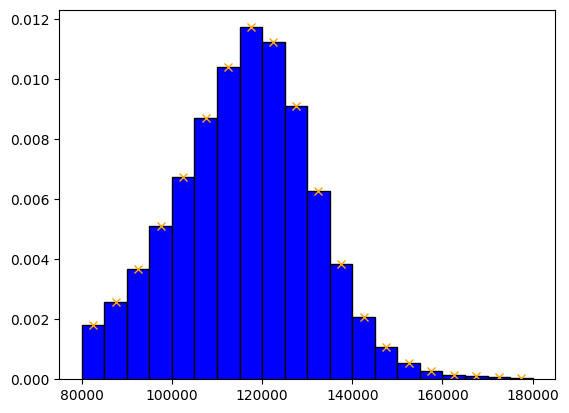

In [27]:
VBFHH_mbb_counts, VBFHH_mbb_bins, _ = plt.hist(VBFHH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=VBFHH_weights)

VBFHH_mbb_err = get_poisson_errors(VBFHH_mbb_counts, VBFHH_weights)

plt.errorbar(mbb_bin_centers, VBFHH_mbb_counts, yerr=VBFHH_mbb_err, marker='x', color='orange', ls='')

In [28]:
VBFHH_mbb_popt, VBFHH_mbb_pcov = curve_fit(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, p0=[120000,11000,2.1,2.4,21,4.5,0.014], sigma=np.mean(VBFHH_mbb_err, axis=0))

VBFHH_mbb_params = get_params(VBFHH_mbb_popt, VBFHH_mbb_pcov)

VBFHH_mbb_ratio, VBFHH_mbb_residuals, VBFHH_mbb_chi_red, VBFHH_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, np.mean(VBFHH_mbb_err, axis=0), VBFHH_mbb_popt)

VBFHH_mbb_legend = get_legend(VBFHH_mbb_popt, VBFHH_mbb_pcov, VBFHH_mbb_chi_red, dscb_labels, dscb_units)

#VBFHH_mbb_popt2, VBFHH_mbb_pcov2 = curve_fit(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, p0=[120000,11000,2.1,2.4,21,4.5,0.35], sigma=np.mean(VBFHH_mbb_err2,axis=0))

#VBFHH_mbb_params2 = get_params(VBFHH_mbb_popt2, VBFHH_mbb_pcov2)

#VBFHH_mbb_ratio2, VBFHH_mbb_residuals2, VBFHH_mbb_chi_red2, VBFHH_mbb_chi2 \
#= fit_evaluation(dscb_func, mbb_bin_centers, VBFHH_mbb_counts, VBFHH_mbb_err2, VBFHH_mbb_popt2)

#VBFHH_mbb_legend2 = get_legend(VBFHH_mbb_popt2, VBFHH_mbb_pcov2, VBFHH_mbb_chi_red2, dscb_labels, dscb_units)

#VBFHH_mbb_popt, VBFHH_mbb_popt2

/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


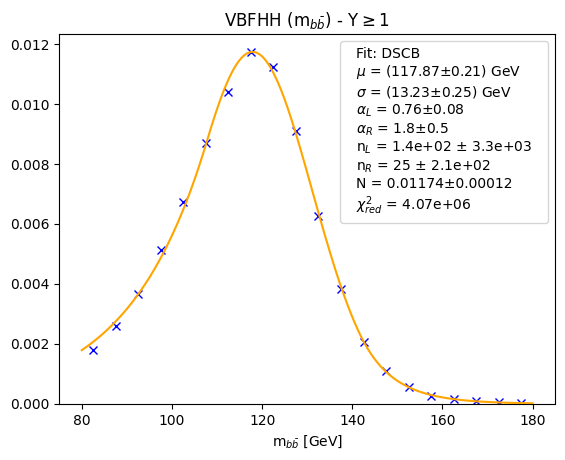

In [29]:
plt.title(r'VBFHH (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*VBFHH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=VBFHH_mbb_legend)

plt.errorbar(mbb_bin_centers, VBFHH_mbb_counts, yerr=VBFHH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(VBFHH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=VBFHH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/VBFHH_mbb_Y1.pdf', format='pdf')

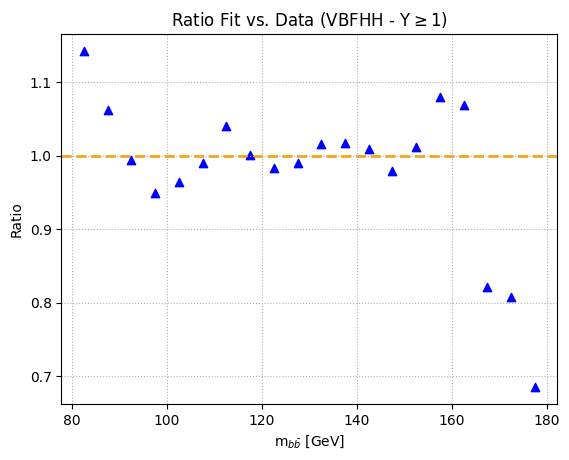

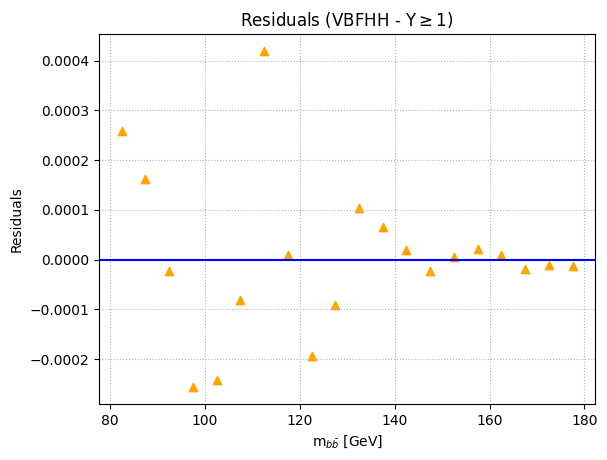

In [30]:
plot_ratio_red(mbb_bin_centers, VBFHH_mbb_ratio, VBFHH_mbb_residuals, r'VBFHH - Y$\geq$1', 'mbb')

---

### VBFHH - m$_{\gamma\gamma}$

In [31]:
#VBFHH_myy_err = get_errors(VBFHH_myy, VBFHH_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

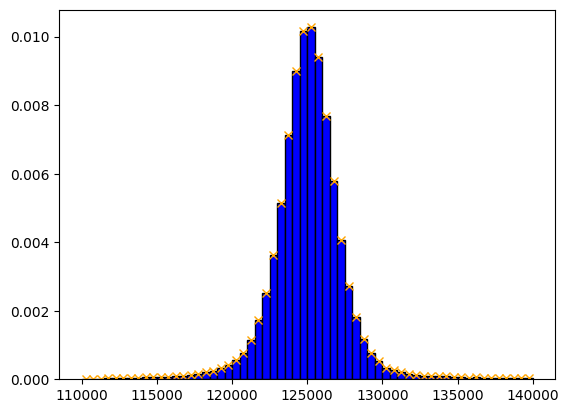

In [32]:
VBFHH_myy_counts, VBFHH_myy_bins, _ = plt.hist(VBFHH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=VBFHH_weights)

VBFHH_myy_err = get_poisson_errors(VBFHH_myy_counts, VBFHH_weights)

plt.errorbar(myy_bin_centers, VBFHH_myy_counts, yerr=VBFHH_myy_err, marker='x', color='orange', ls='')

In [33]:
VBFHH_myy_popt, VBFHH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, VBFHH_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.01], sigma=np.mean(VBFHH_myy_err, axis=0))

VBFHH_myy_params = get_params(VBFHH_myy_popt, VBFHH_myy_pcov)

VBFHH_myy_mu, VBFHH_myy_sig, VBFHH_myy_aL, VBFHH_myy_aR, VBFHH_myy_nL, VBFHH_myy_nR, VBFHH_myy_N \
= get_params_dscb(VBFHH_myy_popt, VBFHH_myy_pcov, '')

VBFHH_myy_ratio, VBFHH_myy_residuals, VBFHH_myy_chi_red, VBFHH_myy_chi = \
fit_evaluation(dscb_func, myy_bin_centers, VBFHH_myy_counts, np.mean(VBFHH_myy_err, axis=0), VBFHH_myy_popt)

VBFHH_myy_legend = get_legend(VBFHH_myy_popt, VBFHH_myy_pcov, VBFHH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


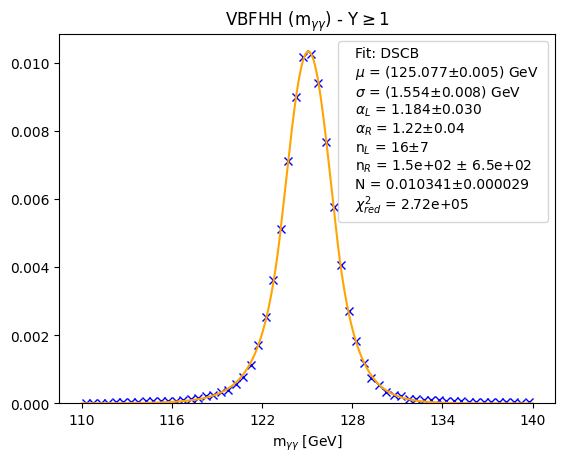

In [34]:
plt.title(r'VBFHH (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*VBFHH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=VBFHH_myy_legend)

plt.errorbar(myy_bin_centers, VBFHH_myy_counts, yerr=VBFHH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(VBFHH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=VBFHH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/VBFHH_myy_Y1.pdf', format='pdf')

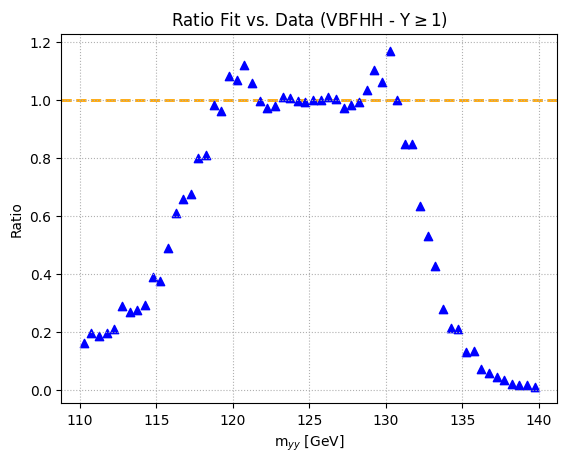

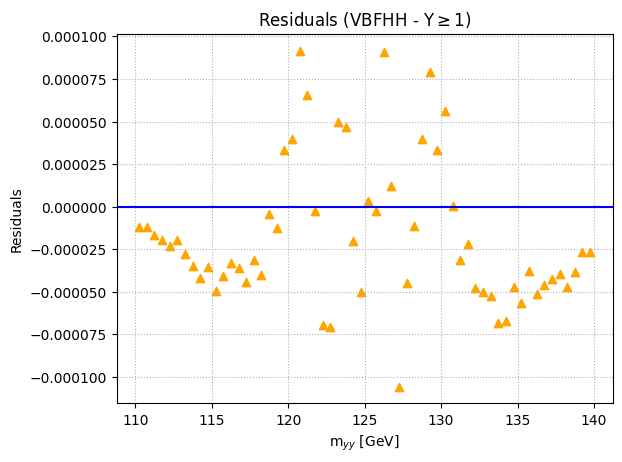

In [35]:
plot_ratio_red(myy_bin_centers, VBFHH_myy_ratio, VBFHH_myy_residuals, r'VBFHH - Y$\geq$1', 'myy')

---
---

## ggFH

In [36]:
ggFH_mbb, ggFH_myy, ggFH_weights = read_data_sens('ggFH.h5', 1)

#ggFH_mbb, ggFH_myy = ggFH_mbb_MeV * 1e-3, ggFH_myy_MeV * 1e-3

### ggFH - $m_{b\bar{b}}$

In [37]:
#ggFH_mbb_err = get_errors(ggFH_mbb, ggFH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

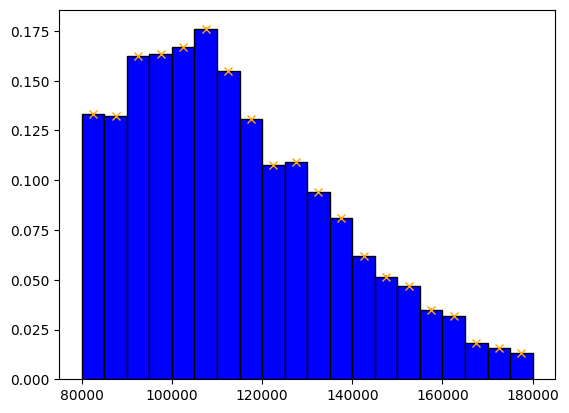

In [38]:
ggFH_mbb_counts, ggFH_mbb_bins, _ = plt.hist(ggFH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFH_weights)

ggFH_mbb_err = get_poisson_errors(ggFH_mbb_counts, ggFH_weights)

plt.errorbar(mbb_bin_centers, ggFH_mbb_counts, yerr=ggFH_mbb_err, marker='x', color='orange', ls='')

In [39]:
ggFH_mbb_popt, ggFH_mbb_pcov = curve_fit(cb_func, mbb_bin_centers, ggFH_mbb_counts, p0=[110000,15000,1.5,15,0.11], sigma=np.mean(ggFH_mbb_err, axis=0))

#ggFH_mbb_a = ufloat(ggFH_mbb_popt[0], np.sqrt(ggFH_mbb_pcov[0][0]))
#ggFH_mbb_b = ufloat(ggFH_mbb_popt[1], np.sqrt(ggFH_mbb_pcov[1][1]))

ggFH_mbb_params = get_params(ggFH_mbb_popt, ggFH_mbb_pcov)

ggFH_mbb_ratio, ggFH_mbb_residuals, ggFH_mbb_chi_red, ggFH_mbb_chi = fit_evaluation(cb_func, mbb_bin_centers, ggFH_mbb_counts, np.mean(ggFH_mbb_err, axis=0), ggFH_mbb_popt)

ggFH_mbb_legend = get_legend(ggFH_mbb_popt, ggFH_mbb_pcov, ggFH_mbb_chi_red, cb_labels, cb_units)

/tmp/ipykernel_336/1638362595.py:2: RuntimeWarning: invalid value encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_336/1638362595.py:5: RuntimeWarning: invalid value encountered in power
  right = N * A * (B - (mu - x) / sigma) ** -n
/tmp/ipykernel_336/1638362595.py:2: RuntimeWarning: overflow encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_336/1638362595.py:5: RuntimeWarning: invalid value encountered in multiply
  right = N * A * (B - (mu - x) / sigma) ** -n


In [40]:
ggFH_mbb_popt, [115000,20000,0.5,0.5,4.5,15,0.11]

(array([1.01821898e+05, 2.65655894e+04, 9.62577724e-01, 1.42105902e+02,
        1.66805289e-01]),
 [115000, 20000, 0.5, 0.5, 4.5, 15, 0.11])

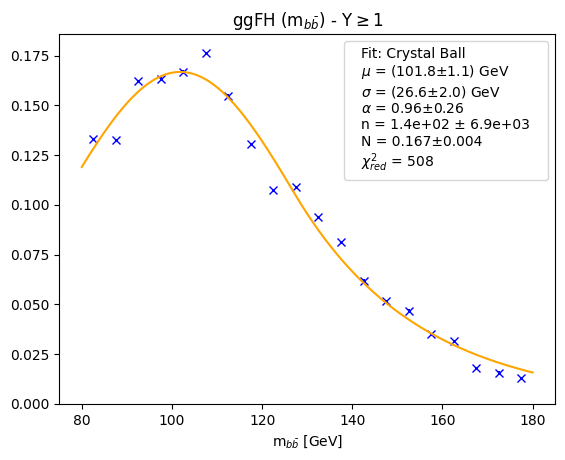

In [41]:
plt.title(r'ggFH (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, cb_func(mbb_plot,*ggFH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFH_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFH_mbb_counts, yerr=ggFH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/ggFH_mbb_Y1.pdf', format='pdf')

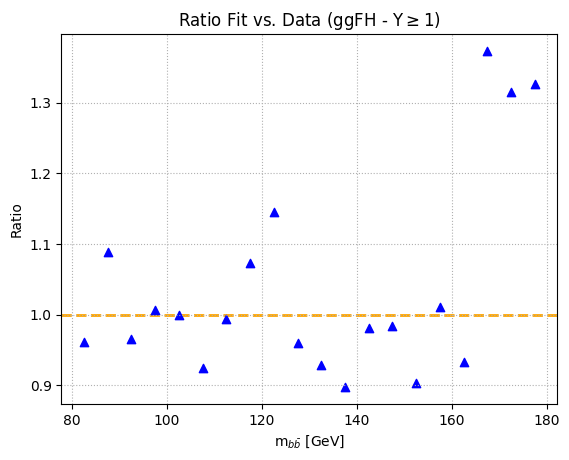

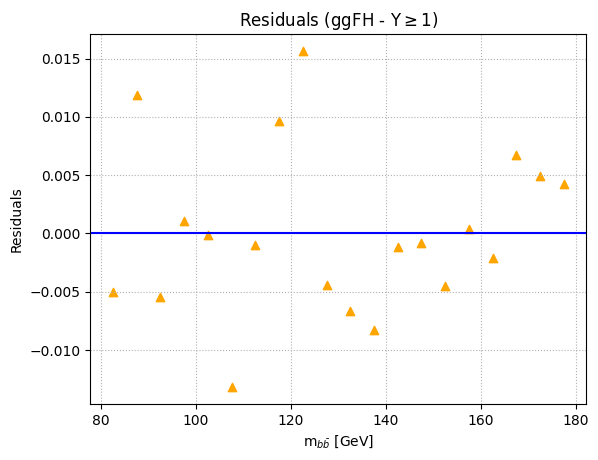

In [42]:
plot_ratio_red(mbb_bin_centers, ggFH_mbb_ratio, ggFH_mbb_residuals, r'ggFH - Y$\geq$1', 'mbb')

---

### ggFH - m$_{\gamma\gamma}$

In [43]:
#ggFH_myy_err = get_errors(ggFH_myy, ggFH_weights, myy_bins, myy_bin_num)

#ggFH_myy_err += 1e-9

<ErrorbarContainer object of 3 artists>

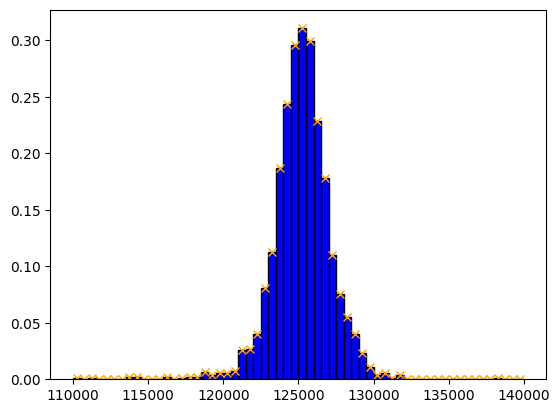

In [44]:
ggFH_myy_counts, ggFH_myy_bins, _ = plt.hist(ggFH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFH_weights)

ggFH_myy_err = get_poisson_errors(ggFH_myy_counts, ggFH_weights)

#ggFH_myy_err = ggFH_myy_err[ggFH_myy_counts > 0]
#ggFH_myy_bins = ggFH_myy_bins[:-1][ggFH_myy_counts > 0] + (myy_max-myy_min)/myy_bin_num/2
#ggFH_myy_counts = ggFH_myy_counts[ggFH_myy_counts > 0]

plt.errorbar(myy_bin_centers, ggFH_myy_counts, yerr=ggFH_myy_err, marker='x', color='orange', ls='')

In [45]:
ggFH_myy_popt, ggFH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFH_myy_counts, p0=[125e3, 1.5e3, 1.64, 3.4, \
       1.3, 1.3, 0.25], sigma=np.mean(ggFH_myy_err, axis=0))

ggFH_myy_params = get_params(ggFH_myy_popt, ggFH_myy_pcov)

ggFH_myy_mu, ggFH_myy_sig, ggFH_myy_aL, ggFH_myy_aR, ggFH_myy_nL, ggFH_myy_nR, ggFH_myy_N \
= get_params_dscb(ggFH_myy_popt, ggFH_myy_pcov, '')

ggFH_myy_ratio, ggFH_myy_residuals, ggFH_myy_chi_red, ggFH_myy_chi = fit_evaluation(dscb_func, myy_bin_centers, ggFH_myy_counts, np.mean(ggFH_myy_err, axis=0), ggFH_myy_popt)

ggFH_myy_legend = get_legend(ggFH_myy_popt, ggFH_myy_pcov, ggFH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


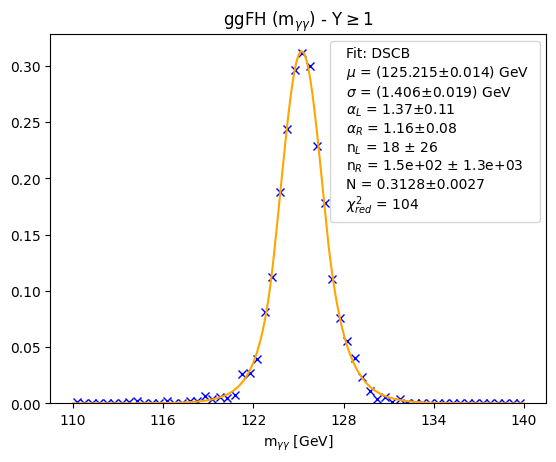

In [46]:
plt.title(r'ggFH (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFH_myy_legend)

plt.errorbar(myy_bin_centers, ggFH_myy_counts, yerr=ggFH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/ggFH_myy_Y1.pdf', format='pdf')

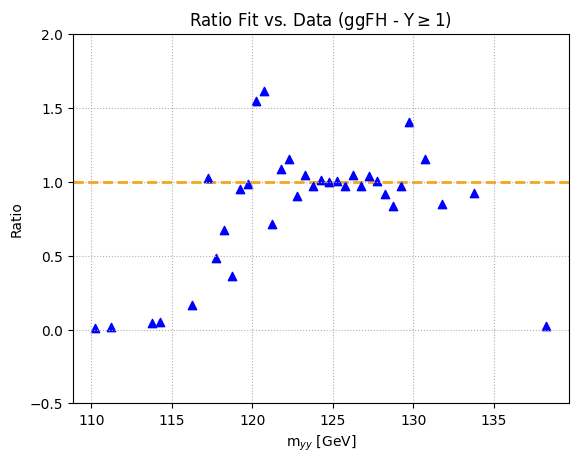

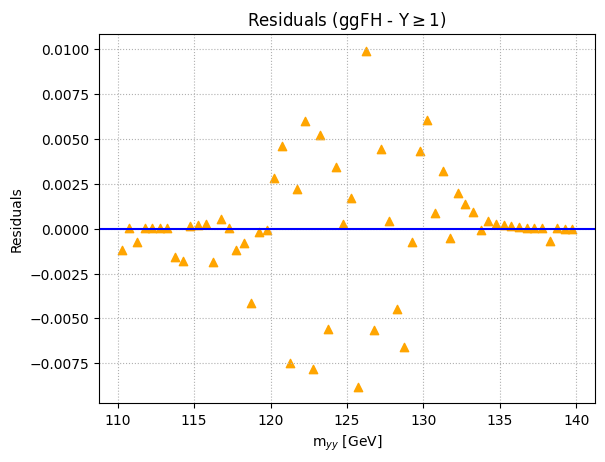

In [47]:
plt.ylim(-0.5, 2)

plot_ratio_red(myy_bin_centers, ggFH_myy_ratio, ggFH_myy_residuals, r'ggFH - Y$\geq$1', 'myy')

---
---

## ttH

In [48]:
ttH_mbb, ttH_myy, ttH_weights = read_data_sens('ttH.h5', 1)

### ttH - m$_{b\bar{b}}$

In [49]:
#ttH_mbb_err = get_errors(ttH_mbb, ttH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

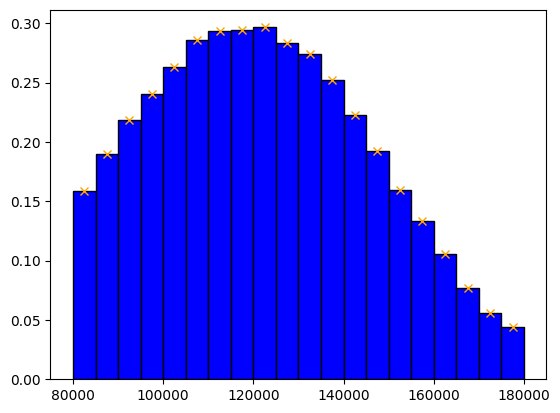

In [50]:
ttH_mbb_counts, ttH_mbb_bins, _ = plt.hist(ttH_mbb, bins=mbb_bin_num, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ttH_weights)

ttH_mbb_err = get_poisson_errors(ttH_mbb_counts, ttH_weights)

plt.errorbar(mbb_bin_centers, ttH_mbb_counts, yerr=ttH_mbb_err, marker='x', color='orange', ls='')

In [51]:
ttH_mbb_bounds = np.array([[0.8e5, 1.8e5], [1e4, 7.8e4],\
                           [0.1, 5], [0.01, 100], [0.1, 200], [0.1, 2000], [0.01, 0.9] ]).T

ttH_mbb_popt, ttH_mbb_pcov = curve_fit(dscb_func, mbb_bin_centers, ttH_mbb_counts, \
                                       p0 = [118500,30000,0.75,1.6,55,6,0.30], sigma=np.mean(ttH_mbb_err, axis=0))

ttH_mbb_params = get_params(ttH_mbb_popt, ttH_mbb_pcov)

ttH_mbb_ratio, ttH_mbb_residuals, ttH_mbb_chi_red, ttH_mbb_chi = fit_evaluation(dscb_func, mbb_bin_centers, ttH_mbb_counts, np.mean(ttH_mbb_err, axis=0), ttH_mbb_popt)

ttH_mbb_legend = get_legend(ttH_mbb_popt, ttH_mbb_pcov, ttH_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


In [52]:
ttH_mbb_popt, ttH_mbb_pcov

(array([1.18467802e+05, 3.01141450e+04, 7.39994749e-01, 1.67496087e+00,
        1.36112330e+02, 1.05796740e+01, 3.01071194e-01]),
 array([[ 2.03481788e+05, -1.58156908e+05, -6.15324689e+01,
         -3.27803697e+01,  6.45640979e+06,  6.57372357e+03,
          2.02004522e-01],
        [-1.58156908e+05,  2.55161012e+05,  5.65312004e+01,
          1.31106803e+02, -5.63158839e+06, -3.04871330e+04,
         -6.74873923e-01],
        [-6.15324689e+01,  5.65312004e+01,  6.77078587e-02,
          1.99798385e-02, -9.89893551e+03, -4.43808408e+00,
          2.85158750e-06],
        [-3.27803697e+01,  1.31106803e+02,  1.99798385e-02,
          8.36756474e-01, -1.87841182e+03, -3.07972717e+02,
         -3.29165055e-04],
        [ 6.45640979e+06, -5.63158839e+06, -9.89893551e+03,
         -1.87841182e+03,  1.59140256e+09,  4.13515729e+05,
         -2.15667879e+00],
        [ 6.57372357e+03, -3.04871330e+04, -4.43808408e+00,
         -3.07972717e+02,  4.13515729e+05,  1.23890008e+05,
          7.660

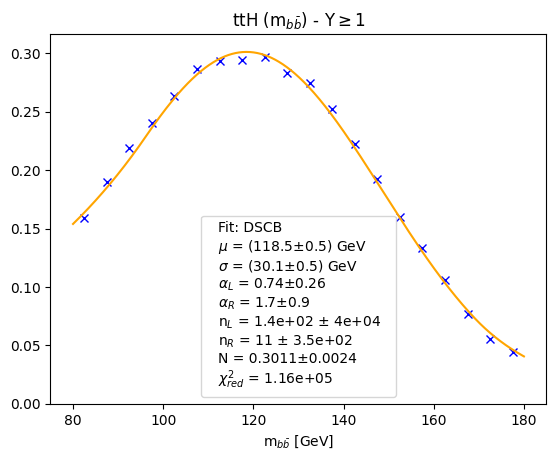

In [53]:
plt.title(r'ttH (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ttH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ttH_mbb_legend)

#plt.plot(mbb_plot, 0.3028 * np.exp(-0.5 * (mbb_plot-118e3)**2/(30.4e3)**2), color='red', linewidth=4)

plt.errorbar(mbb_bin_centers, ttH_mbb_counts, yerr=ttH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ttH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ttH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/ttH_mbb_Y1.pdf', format='pdf')

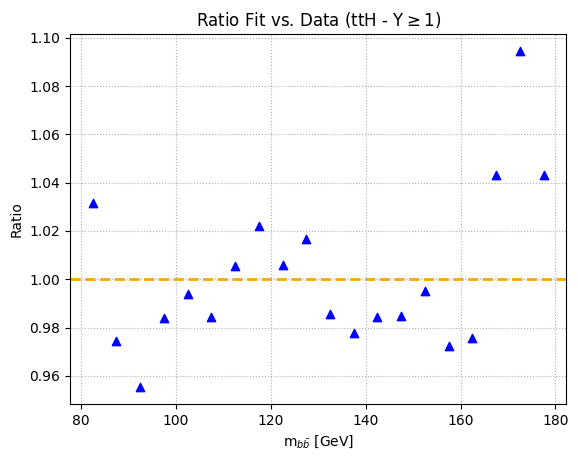

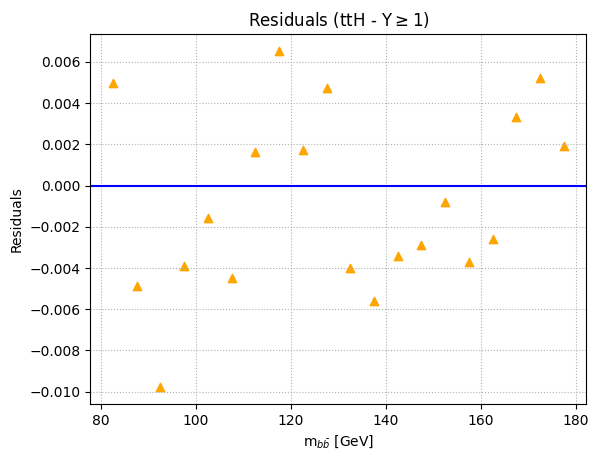

In [54]:
plot_ratio_red(mbb_bin_centers, ttH_mbb_ratio, ttH_mbb_residuals, r'ttH - Y$\geq$1', 'mbb')

---

### ttH - m$_{\gamma\gamma}$

In [55]:
#ttH_myy_err = get_errors(ttH_myy, ttH_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

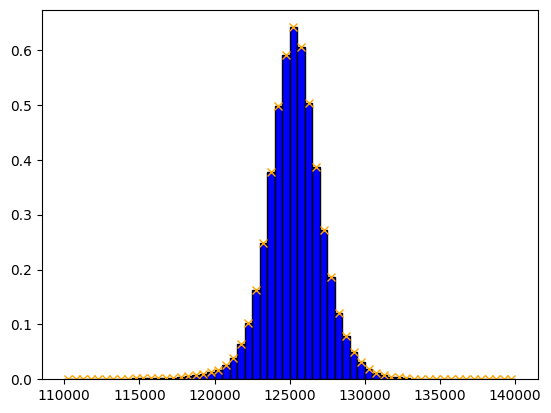

In [56]:
ttH_myy_counts, ttH_myy_bins, _ = plt.hist(ttH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ttH_weights)

ttH_myy_err = get_poisson_errors(ttH_myy_counts, ttH_weights)

plt.errorbar(myy_bin_centers, ttH_myy_counts, yerr=ttH_myy_err, marker='x', color='orange', ls='')

In [57]:
ttH_myy_popt, ttH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ttH_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 2.5], sigma=np.mean(ttH_myy_err, axis=0))

ttH_myy_params = get_params(ttH_myy_popt, ttH_myy_pcov)

ttH_myy_mu, ttH_myy_sig, ttH_myy_aL, ttH_myy_aR, ttH_myy_nL, ttH_myy_nR, ttH_myy_N \
= get_params_dscb(ttH_myy_popt, ttH_myy_pcov, '')

ttH_myy_ratio, ttH_myy_residuals, ttH_myy_chi_red, ttH_myy_chi = fit_evaluation(dscb_func, myy_bin_centers, ttH_myy_counts, np.mean(ttH_myy_err, axis=0), ttH_myy_popt)

ttH_myy_legend = get_legend(ttH_myy_popt, ttH_myy_pcov, ttH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


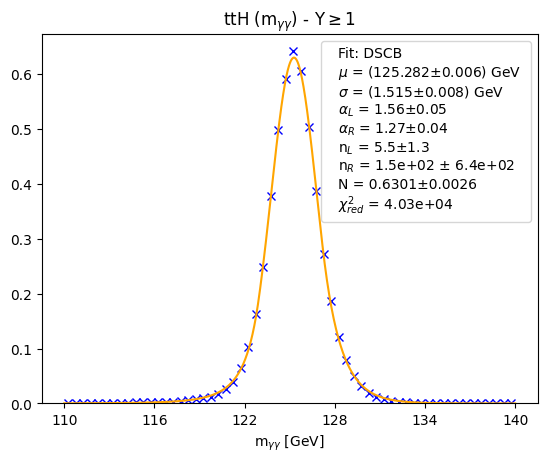

In [58]:
plt.title(r'ttH (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ttH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ttH_myy_legend)

plt.errorbar(myy_bin_centers, ttH_myy_counts, yerr=ttH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ttH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ttH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/ttH_myy_Y1.pdf', format='pdf')

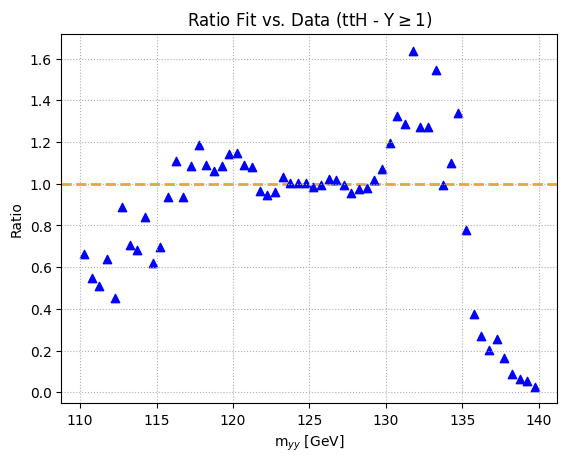

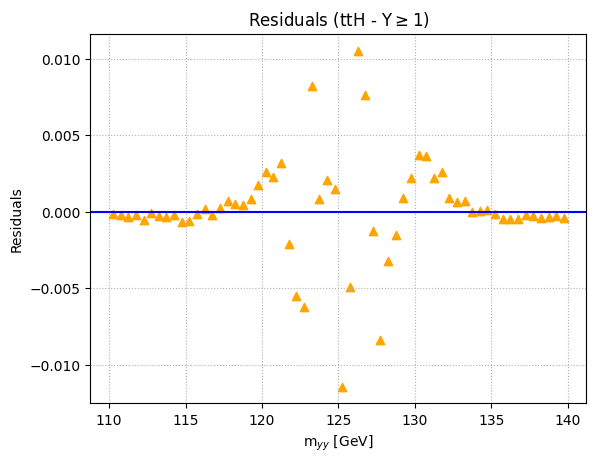

In [59]:
plot_ratio_red(myy_bin_centers, ttH_myy_ratio, ttH_myy_residuals, r'ttH - Y$\geq$1', 'myy')

---
---

## qqZH

In [60]:
qqZH_mbb, qqZH_myy, qqZH_weights = read_data_sens('qqZH.h5', 1)

### qqZH - m$_{b\bar{b}}$

In [61]:
#qqZH_mbb_err = get_errors(qqZH_mbb, qqZH_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

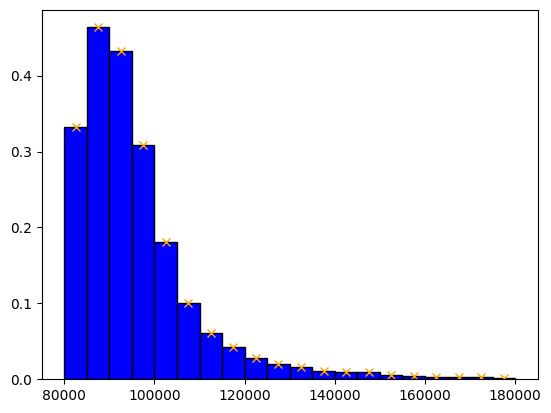

In [62]:
qqZH_mbb_counts, qqZH_mbb_bins, _ = plt.hist(qqZH_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=qqZH_weights)

qqZH_mbb_err = get_poisson_errors(qqZH_mbb_counts, qqZH_weights)

plt.errorbar(mbb_bin_centers, qqZH_mbb_counts, yerr=qqZH_mbb_err, marker='x', color='orange', ls='')

In [63]:
qqZH_mbb_popt, qqZH_mbb_pcov = curve_fit(cb_func, mbb_bin_centers, qqZH_mbb_counts, \
                                       p0 = [92e3, 0.3e3, 3, 1, 0.2], sigma=np.mean(qqZH_mbb_err, axis=0))

qqZH_mbb_params = get_params(qqZH_mbb_popt, qqZH_mbb_pcov)

qqZH_mbb_ratio, qqZH_mbb_residuals, qqZH_mbb_chi_red, qqZH_mbb_chi = fit_evaluation(cb_func, mbb_bin_centers, qqZH_mbb_counts, np.mean(qqZH_mbb_err, axis=0), qqZH_mbb_popt)

qqZH_mbb_legend = get_legend(qqZH_mbb_popt, qqZH_mbb_pcov, qqZH_mbb_chi_red, cb_labels, cb_units)

/tmp/ipykernel_336/1638362595.py:5: RuntimeWarning: invalid value encountered in power
  right = N * A * (B - (mu - x) / sigma) ** -n
/tmp/ipykernel_336/1638362595.py:2: RuntimeWarning: overflow encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_336/1638362595.py:2: RuntimeWarning: invalid value encountered in scalar multiply
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)
/tmp/ipykernel_336/1638362595.py:2: RuntimeWarning: invalid value encountered in scalar power
  A = (n / np.abs(alpha)) ** n * np.exp(-0.5 * alpha ** 2)


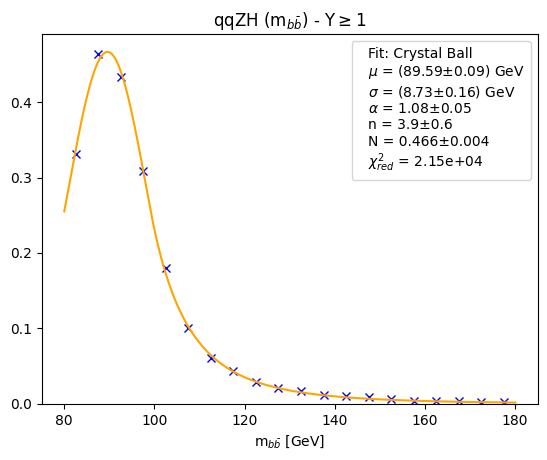

In [64]:
plt.title(r'qqZH (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, cb_func(mbb_plot,*qqZH_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=qqZH_mbb_legend)

plt.errorbar(mbb_bin_centers, qqZH_mbb_counts, yerr=qqZH_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(qqZH_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=qqZH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/qqZH_mbb_Y1.pdf', format='pdf')

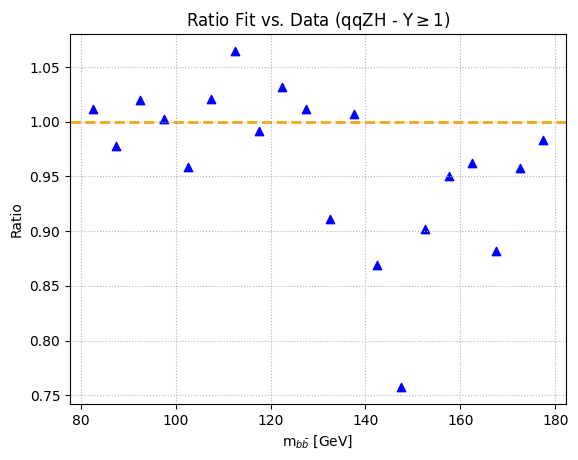

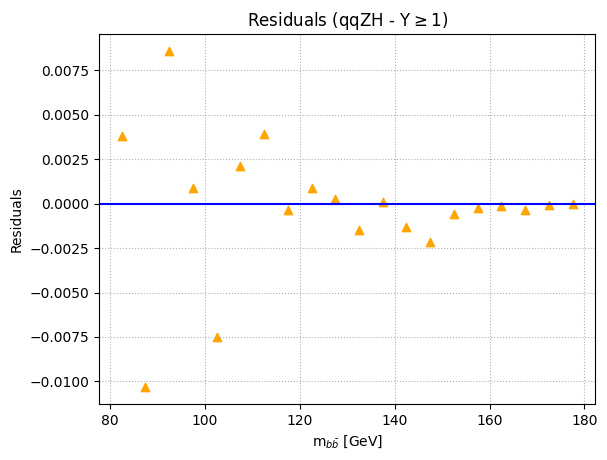

In [65]:
plot_ratio_red(mbb_bin_centers, qqZH_mbb_ratio, qqZH_mbb_residuals, r'qqZH - Y$\geq$1', 'mbb')

---

### qqZH - m$_{\gamma\gamma}$

In [66]:
#qqZH_myy_err = get_errors(qqZH_myy, qqZH_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

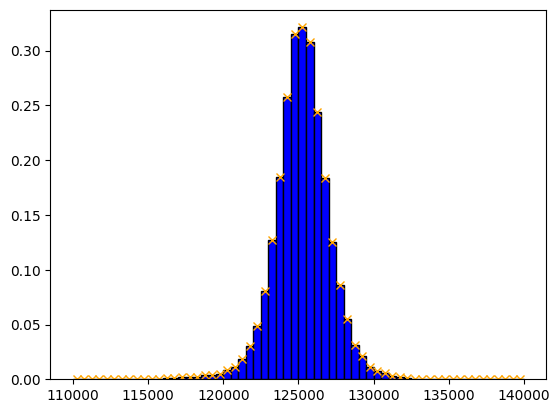

In [67]:
qqZH_myy_counts, qqZH_myy_bins, _ = plt.hist(qqZH_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=qqZH_weights)

qqZH_myy_err = get_poisson_errors(qqZH_myy_counts, qqZH_weights)

#qqZH_myy_err = qqZH_myy_err[qqZH_myy_counts > 0]
#qqZH_myy_bins = qqZH_myy_bins[:-1][qqZH_myy_counts > 0] + (myy_max-myy_min)/myy_bin_num/2
#qqZH_myy_counts = qqZH_myy_counts[qqZH_myy_counts > 0]

plt.errorbar(myy_bin_centers, qqZH_myy_counts, yerr=qqZH_myy_err, marker='x', color='orange', ls='')

In [68]:
qqZH_myy_popt, qqZH_myy_pcov = curve_fit(dscb_func, myy_bin_centers, qqZH_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       4, 12, 1.1], sigma=np.mean(qqZH_myy_err, axis=0))

qqZH_myy_mu, ggFH_myy_sig, qqZH_myy_aL, qqZH_myy_aR, qqZH_myy_nL, qqZH_myy_nR, qqZH_myy_N \
= get_params_dscb(qqZH_myy_popt, qqZH_myy_pcov, '')

qqZH_myy_ratio, qqZH_myy_residuals, qqZH_myy_chi_red, qqZH_myy_chi = fit_evaluation(dscb_func, myy_bin_centers, qqZH_myy_counts, np.mean(qqZH_myy_err, axis=0), qqZH_myy_popt)

qqZH_myy_legend = get_legend(qqZH_myy_popt, qqZH_myy_pcov, qqZH_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: overflow encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in multiply
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/2443743946.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(y == 0, np.nan, func(x,*params) / y)


In [69]:
qqZH_myy_popt

array([1.25229154e+05, 1.43599106e+03, 1.39608590e+00, 1.22727989e+00,
       1.68683925e+01, 1.48085622e+02, 3.24504026e-01])

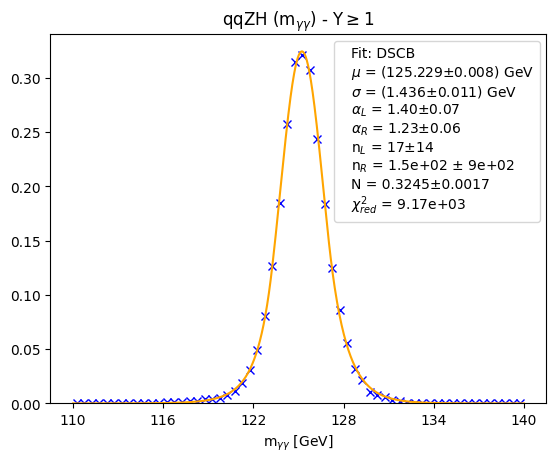

In [70]:
plt.title(r'qqZH (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*qqZH_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=qqZH_myy_legend)

plt.errorbar(myy_bin_centers, qqZH_myy_counts, yerr=qqZH_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(qqZH_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=qqZH_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/qqZH_myy_Y1.pdf', format='pdf')

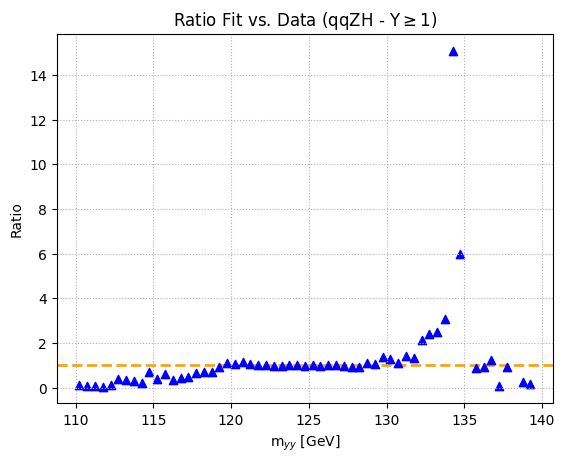

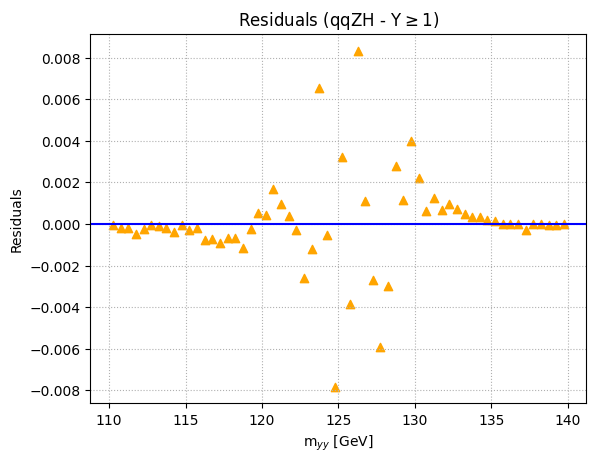

In [71]:
plot_ratio_red(myy_bin_centers, qqZH_myy_ratio, qqZH_myy_residuals, r'qqZH - Y$\geq$1', 'myy')

---
---

## yybb

In [72]:
yybb_mbb, yybb_myy, yybb_weights = read_data_sens('yybb.h5', 1)

### yybb - m$_{b\bar{b}}$

In [73]:
#yybb_mbb_err = get_errors(yybb_mbb, yybb_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

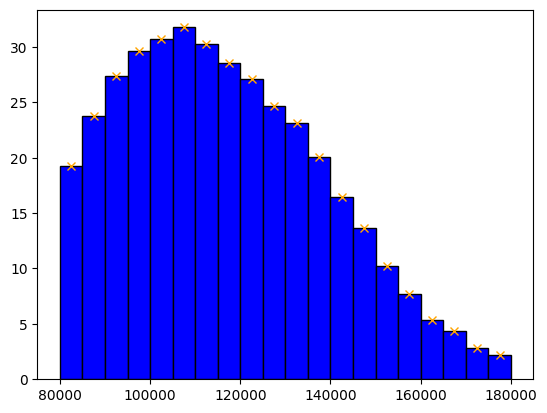

In [74]:
yybb_mbb_counts, yybb_mbb_bins, _ = plt.hist(yybb_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=yybb_weights)

yybb_mbb_err = get_poisson_errors(yybb_mbb_counts, yybb_weights)

plt.errorbar(mbb_bin_centers, yybb_mbb_counts, yerr=yybb_mbb_err, marker='x', color='orange', ls='')

In [75]:
yybb_mbb_popt, yybb_mbb_pcov = curve_fit(gauss_func, mbb_bin_centers, yybb_mbb_counts,\
                                         p0=[105000,27000,30], sigma=np.mean(yybb_mbb_err, axis=0))

#yybb_mbb_a = ufloat(yybb_mbb_popt[0], np.sqrt(yybb_mbb_pcov[0][0]))
#yybb_mbb_b = ufloat(yybb_mbb_popt[1], np.sqrt(yybb_mbb_pcov[1][1]))

yybb_mbb_params = get_params(yybb_mbb_popt, yybb_mbb_pcov)

yybb_mbb_ratio, yybb_mbb_residuals, yybb_mbb_chi_red, yybb_mbb_chi = fit_evaluation(gauss_func, mbb_bin_centers, yybb_mbb_counts, np.mean(yybb_mbb_err, axis=0), yybb_mbb_popt)

yybb_mbb_legend = get_legend(yybb_mbb_popt, yybb_mbb_pcov, yybb_mbb_chi_red, gauss_labels, gauss_units)

#yybb_mbb_pcov[4][4]

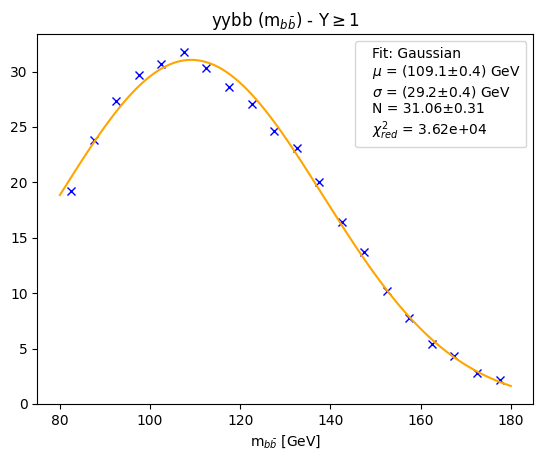

In [76]:
plt.title(r'yybb (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, gauss_func(mbb_plot,*yybb_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=yybb_mbb_legend)

#plt.plot(mbb_plot, 31 * np.exp(-0.5 * (mbb_plot-109.1357e3)**2/(29.16e3)**2), color='red', linewidth=4)

plt.errorbar(mbb_bin_centers, yybb_mbb_counts, yerr=yybb_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(yybb_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=yybb_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/yybb_mbb_Y1.pdf', format='pdf')

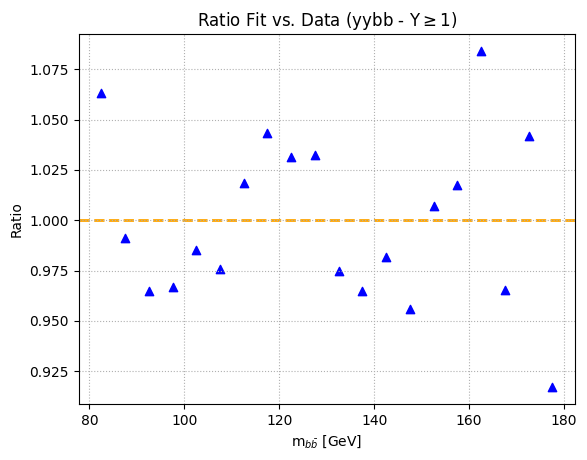

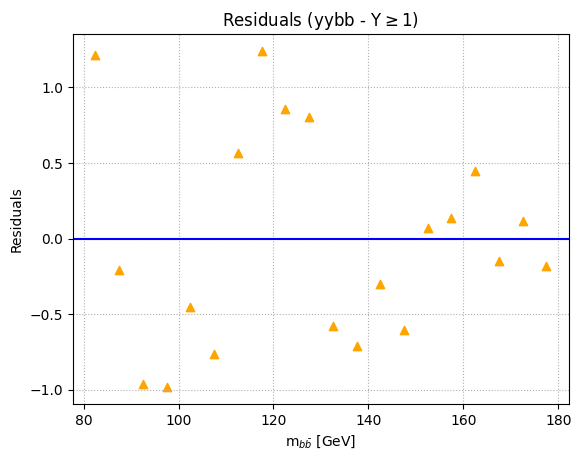

In [77]:
plot_ratio_red(mbb_bin_centers, yybb_mbb_ratio, yybb_mbb_residuals, r'yybb - Y$\geq$1', 'mbb')

---

### yybb - m$_{\gamma\gamma}$

In [78]:
#yybb_myy_err = get_errors(yybb_myy, yybb_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

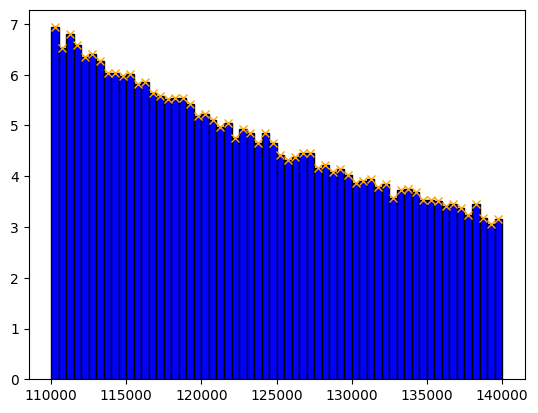

In [79]:
yybb_myy_counts, yybb_myy_bins, _ = plt.hist(yybb_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=yybb_weights)

yybb_myy_err = get_poisson_errors(yybb_myy_counts, yybb_weights)

plt.errorbar(myy_bin_centers, yybb_myy_counts, yerr=yybb_myy_err, marker='x', color='orange', ls='')

In [80]:
yybb_myy_popt, yybb_myy_pcov = curve_fit(exp_fit, myy_bin_centers, yybb_myy_counts, p0=[0.7,1.54e-5], sigma=np.mean(yybb_myy_err, axis=0))

yybb_myy_ratio, yybb_myy_residuals, yybb_myy_chi_red, yybb_myy_chi = fit_evaluation(exp_fit, myy_bin_centers, yybb_myy_counts, np.mean(yybb_myy_err, axis=0), yybb_myy_popt)

yybb_myy_legend = get_legend(yybb_myy_popt, yybb_myy_pcov, yybb_myy_chi_red, exp_fit_labels, exp_fit_units)

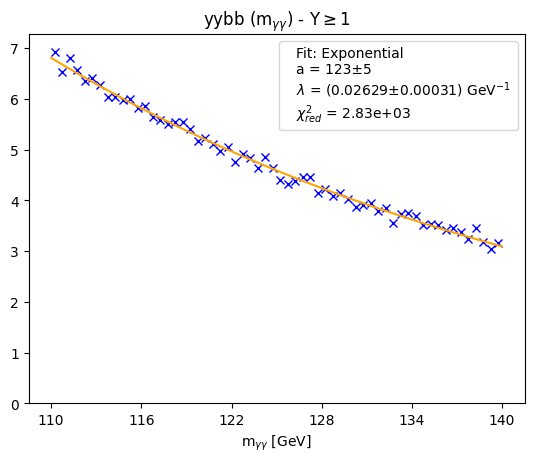

In [81]:
plt.title(r'yybb (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, exp_fit(myy_plot,*yybb_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=yybb_myy_legend)

plt.errorbar(myy_bin_centers, yybb_myy_counts, yerr=yybb_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(yybb_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=yybb_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/yybb_myy_Y1.pdf', format='pdf')

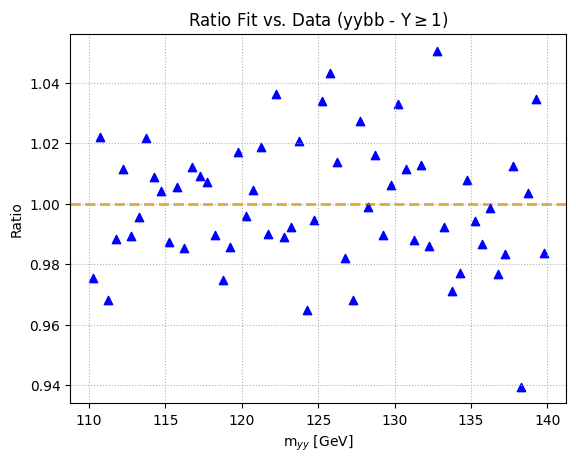

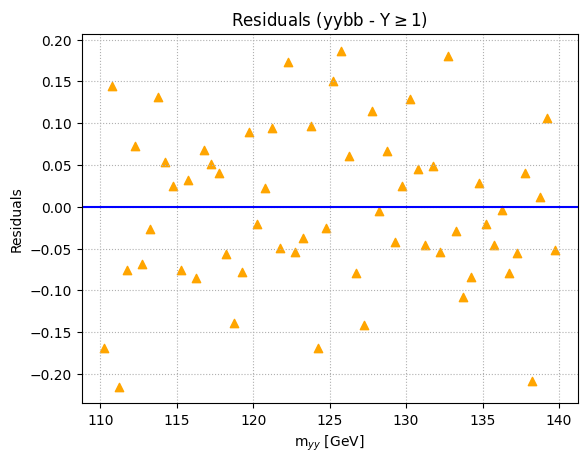

In [82]:
plot_ratio_red(myy_bin_centers, yybb_myy_ratio, yybb_myy_residuals, r'yybb - Y$\geq$1', 'myy')

---
---

## ggFHH_kl1

In [83]:
ggFHH_kl1_mbb, ggFHH_kl1_myy, ggFHH_kl1_weights = read_data_sens('ggFHH_kl1.h5', 1)

### ggFHH_kl1 - m$_{b\bar{b}}$

In [84]:
#ggFHH_kl1_mbb_err = get_errors(ggFHH_kl1_mbb, ggFHH_kl1_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

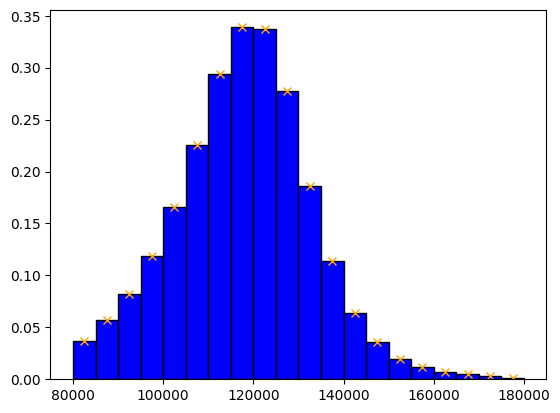

In [85]:
ggFHH_kl1_mbb_counts, ggFHH_kl1_mbb_bins, _ = plt.hist(ggFHH_kl1_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl1_weights)

ggFHH_kl1_mbb_err = get_poisson_errors(ggFHH_kl1_mbb_counts, ggFHH_kl1_weights)

plt.errorbar(mbb_bin_centers, ggFHH_kl1_mbb_counts, yerr=ggFHH_kl1_mbb_err, marker='x', color='orange', ls='')

In [86]:
ggFHH_kl1_mbb_popt, ggFHH_kl1_mbb_pcov = curve_fit(dscb_func, mbb_bin_centers, ggFHH_kl1_mbb_counts, p0=[120000,11000,2.1,2.4,3.5,4.5,0.35], sigma=np.mean(ggFHH_kl1_mbb_err, axis=0))

ggFHH_kl1_mbb_params = get_params(ggFHH_kl1_mbb_popt, ggFHH_kl1_mbb_pcov)

ggFHH_kl1_mbb_ratio, ggFHH_kl1_mbb_residuals, ggFHH_kl1_mbb_chi_red, ggFHH_kl1_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, ggFHH_kl1_mbb_counts, np.mean(ggFHH_kl1_mbb_err, axis=0), ggFHH_kl1_mbb_popt)

ggFHH_kl1_mbb_legend = get_legend(ggFHH_kl1_mbb_popt, ggFHH_kl1_mbb_pcov, ggFHH_kl1_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


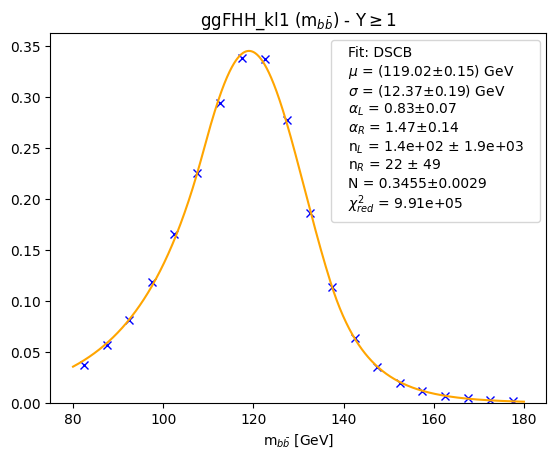

In [87]:
plt.title(r'ggFHH_kl1 (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ggFHH_kl1_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl1_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFHH_kl1_mbb_counts, yerr=ggFHH_kl1_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl1_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl1_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/ggFHH_kl1_mbb_Y1.pdf', format='pdf')

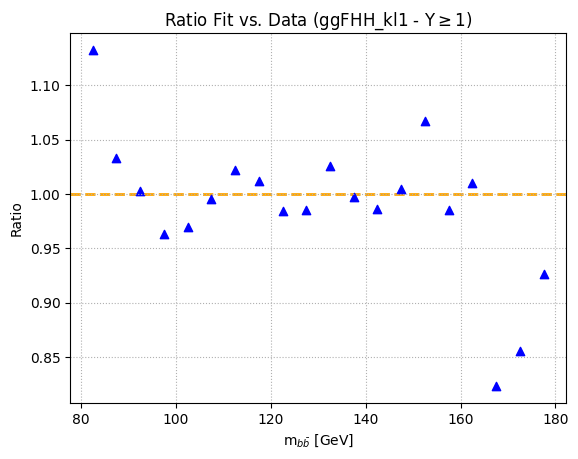

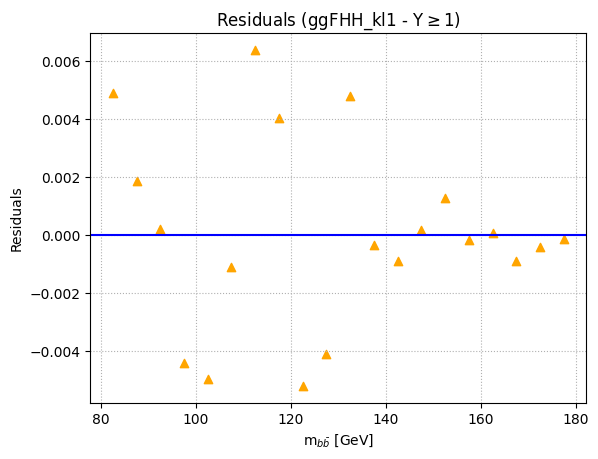

In [88]:
plot_ratio_red(mbb_bin_centers, ggFHH_kl1_mbb_ratio, ggFHH_kl1_mbb_residuals, r'ggFHH_kl1 - Y$\geq$1', 'mbb')

---

### ggFHH_kl1 - m$_{\gamma\bar{\gamma}}$

In [89]:
#ggFHH_kl1_myy_err = get_errors(ggFHH_kl1_myy, ggFHH_kl1_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

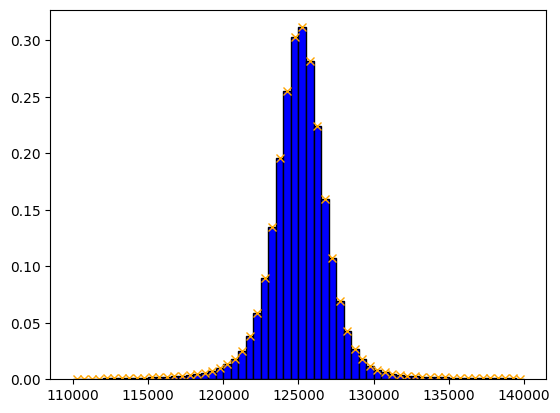

In [90]:
ggFHH_kl1_myy_counts, ggFHH_kl1_myy_bins, _ = plt.hist(ggFHH_kl1_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl1_weights)

ggFHH_kl1_myy_err = get_poisson_errors(ggFHH_kl1_myy_counts, ggFHH_kl1_weights)

plt.errorbar(myy_bin_centers, ggFHH_kl1_myy_counts, yerr=ggFHH_kl1_myy_err, marker='x', color='orange', ls='')

In [91]:
ggFHH_kl1_myy_popt, ggFHH_kl1_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFHH_kl1_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 0.5], sigma=np.mean(ggFHH_kl1_myy_err, axis=0))

ggFHH_kl1_myy_ratio, ggFHH_kl1_myy_residuals, ggFHH_kl1_myy_chi_red, ggFHH_kl1_myy_chi \
= fit_evaluation(dscb_func, myy_bin_centers, ggFHH_kl1_myy_counts, np.mean(ggFHH_kl1_myy_err, axis=0), ggFHH_kl1_myy_popt)

ggFHH_kl1_myy_legend = get_legend(ggFHH_kl1_myy_popt, ggFHH_kl1_myy_pcov, ggFHH_kl1_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


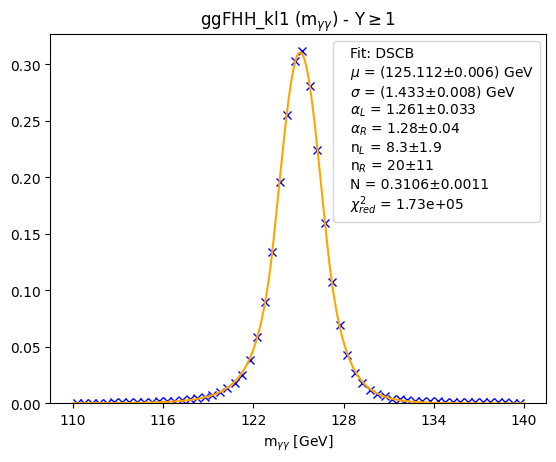

In [92]:
plt.title(r'ggFHH_kl1 (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFHH_kl1_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl1_myy_legend)

plt.errorbar(myy_bin_centers, ggFHH_kl1_myy_counts, yerr=ggFHH_kl1_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl1_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl1_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/ggFHH_kl1_myy_Y1.pdf', format='pdf')

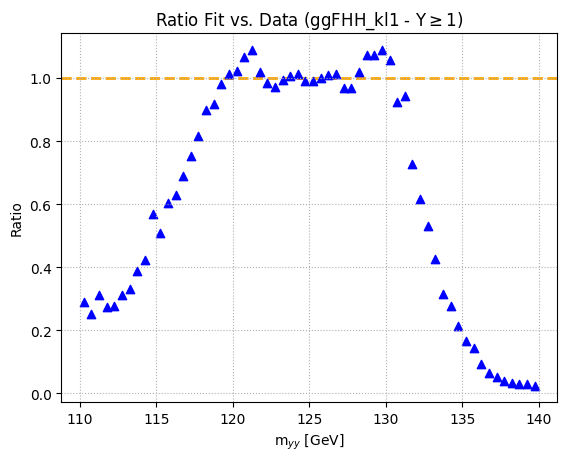

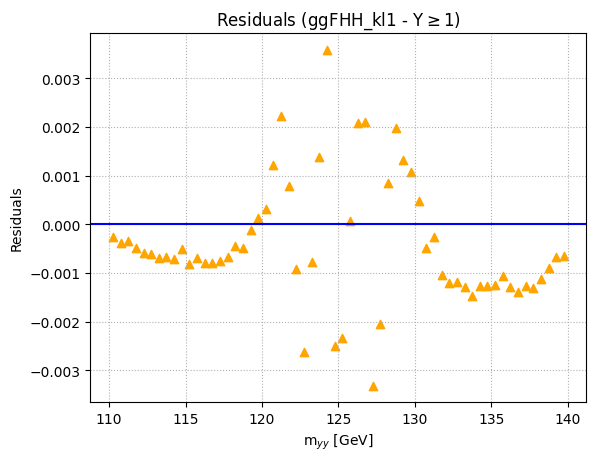

In [93]:
plot_ratio_red(myy_bin_centers, ggFHH_kl1_myy_ratio, ggFHH_kl1_myy_residuals, r'ggFHH_kl1 - Y$\geq$1', 'myy')

---
---

## ggFHH_kl10

In [94]:
ggFHH_kl10_mbb, ggFHH_kl10_myy, ggFHH_kl10_weights = read_data_sens('ggFHH_kl10.h5', 1)

### ggFHH_kl10 - m$_{b\bar{b}}$

In [95]:
#ggFHH_kl10_mbb_err = get_errors(ggFHH_kl10_mbb, ggFHH_kl10_weights, mbb_bins, mbb_bin_num)

<ErrorbarContainer object of 3 artists>

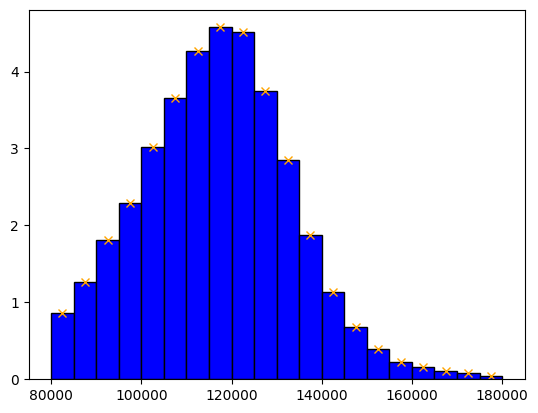

In [96]:
ggFHH_kl10_mbb_counts, ggFHH_kl10_mbb_bins, _ = plt.hist(ggFHH_kl10_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl10_weights)

ggFHH_kl10_mbb_err = get_poisson_errors(ggFHH_kl10_mbb_counts, ggFHH_kl10_weights)

plt.errorbar(mbb_bin_centers, ggFHH_kl10_mbb_counts, yerr=ggFHH_kl10_mbb_err, marker='x', color='orange', ls='')

In [97]:
ggFHH_kl10_mbb_popt, ggFHH_kl10_mbb_pcov = \
curve_fit(dscb_func, mbb_bin_centers, ggFHH_kl10_mbb_counts, p0=[120000,11000,2.1,2.4,3.5,4.5,4.0], sigma=np.mean(ggFHH_kl10_mbb_err, axis=0))

ggFHH_kl10_mbb_params = get_params(ggFHH_kl10_mbb_popt, ggFHH_kl10_mbb_pcov)

ggFHH_kl10_mbb_ratio, ggFHH_kl10_mbb_residuals, ggFHH_kl10_mbb_chi_red, ggFHH_kl10_mbb_chi \
= fit_evaluation(dscb_func, mbb_bin_centers, ggFHH_kl10_mbb_counts, np.mean(ggFHH_kl10_mbb_err, axis=0), ggFHH_kl10_mbb_popt)

ggFHH_kl10_mbb_legend = get_legend(ggFHH_kl10_mbb_popt, ggFHH_kl10_mbb_pcov, ggFHH_kl10_mbb_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R
/tmp/ipykernel_336/433496356.py:21: RuntimeWarning: invalid value encountered in scalar power
  A_R = (n_R / np.abs(alpha_R)) ** n_R * np.exp(-0.5 * alpha_R ** 2)
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: invalid value encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:7: RuntimeWarning: overflow encountered in scalar power
  A_L = (n_L / np.abs(alpha_L)) ** n_L * np.exp(-0.5 * alpha_L ** 2)
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in multiply
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: overflow encountered in scalar multiply
  lef

/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


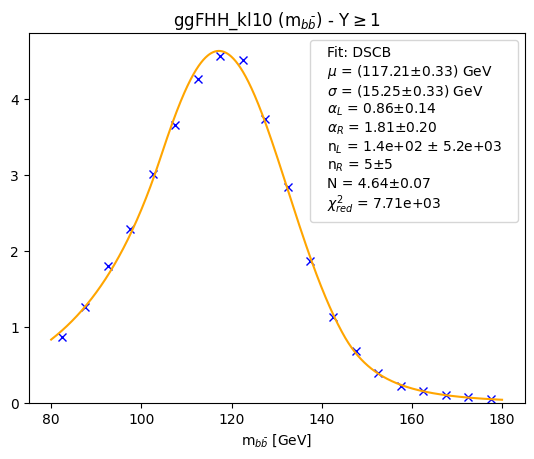

In [98]:
plt.title(r'ggFHH_kl10 (m$_{b\bar{b}}$) - Y$\geq$1')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))


plt.plot(mbb_plot, dscb_func(mbb_plot,*ggFHH_kl10_mbb_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl10_mbb_legend)

plt.errorbar(mbb_bin_centers, ggFHH_kl10_mbb_counts, yerr=ggFHH_kl10_mbb_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl10_mbb, bins=mbb_bins, range=mbb_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl10_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-mbb/ggFHH_kl10_mbb_Y1.pdf', format='pdf')

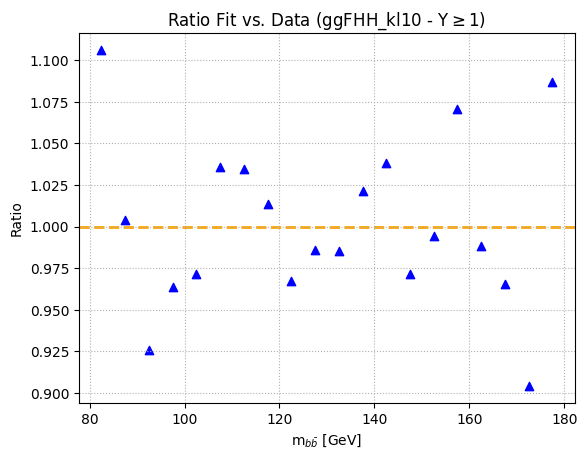

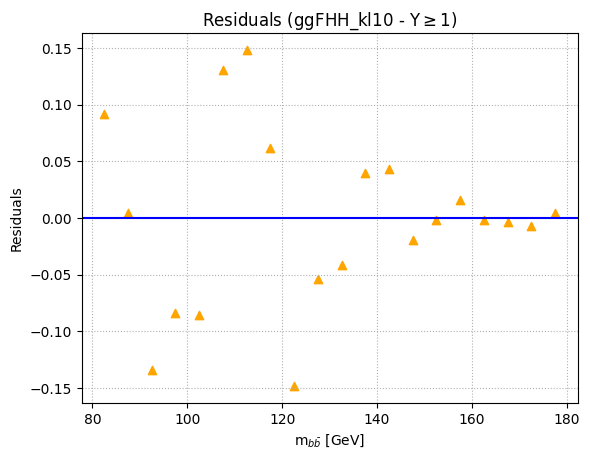

In [99]:
plot_ratio_red(mbb_bin_centers, ggFHH_kl10_mbb_ratio, ggFHH_kl10_mbb_residuals, r'ggFHH_kl10 - Y$\geq$1', 'mbb')

---
---

### ggFHH_kl10 - m$_{\gamma\gamma}$

In [100]:
#ggFHH_kl10_myy_err = get_errors(ggFHH_kl10_myy, ggFHH_kl10_weights, myy_bins, myy_bin_num)

<ErrorbarContainer object of 3 artists>

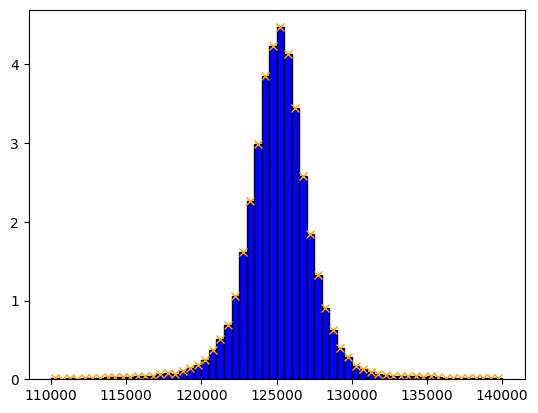

In [101]:
ggFHH_kl10_myy_counts, ggFHH_kl10_myy_bins, _ = plt.hist(ggFHH_kl10_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=ggFHH_kl10_weights)

ggFHH_kl10_myy_err = get_poisson_errors(ggFHH_kl10_myy_counts, ggFHH_kl10_weights)

plt.errorbar(myy_bin_centers, ggFHH_kl10_myy_counts, yerr=ggFHH_kl10_myy_err, marker='x', color='orange', ls='')

In [102]:
ggFHH_kl10_myy_popt, ggFHH_kl10_myy_pcov = curve_fit(dscb_func, myy_bin_centers, ggFHH_kl10_myy_counts, p0=[125e3, 2.5e3, 1.64, 1.64612321e+00, \
       1.3, 13, 7], sigma=np.mean(ggFHH_kl10_myy_err, axis=0))

ggFHH_kl10_myy_ratio, ggFHH_kl10_myy_residuals, ggFHH_kl10_myy_chi_red, ggFHH_kl10_myy_chi \
= fit_evaluation(dscb_func, myy_bin_centers, ggFHH_kl10_myy_counts, np.mean(ggFHH_kl10_myy_err, axis=0), ggFHH_kl10_myy_popt)

ggFHH_kl10_myy_legend = get_legend(ggFHH_kl10_myy_popt, ggFHH_kl10_myy_pcov, ggFHH_kl10_myy_chi_red, dscb_labels, dscb_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L
/tmp/ipykernel_336/433496356.py:26: RuntimeWarning: invalid value encountered in power
  right = N * A_R * (B_R - (mu - x) / sigma) ** -n_R


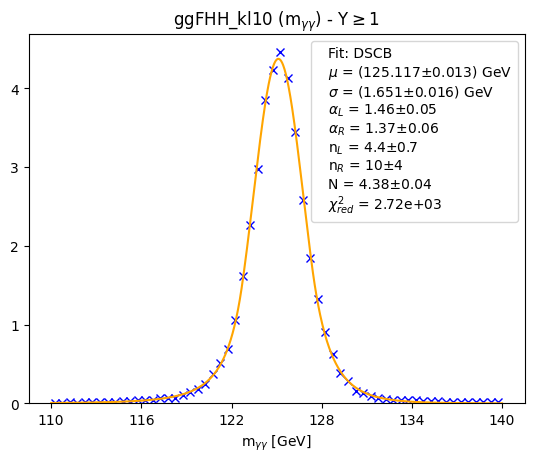

In [103]:
plt.title(r'ggFHH_kl10 (m$_{\gamma\gamma}$) - Y$\geq$1')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, dscb_func(myy_plot,*ggFHH_kl10_myy_popt), color='orange', linewidth=1.5, zorder=5, \
        label=ggFHH_kl10_myy_legend)

plt.errorbar(myy_bin_centers, ggFHH_kl10_myy_counts, yerr=ggFHH_kl10_myy_err, marker='x', color='blue', ls='')

_, _, _ =plt.hist(ggFHH_kl10_myy, bins=myy_bins, range=myy_range, color='white',\
                                    edgecolor='white', weights=ggFHH_kl10_weights)

_=plt.legend(handlelength=0)

plt.savefig('./Plots/Y1-myy/ggFHH_kl10_myy_Y1.pdf', format='pdf')

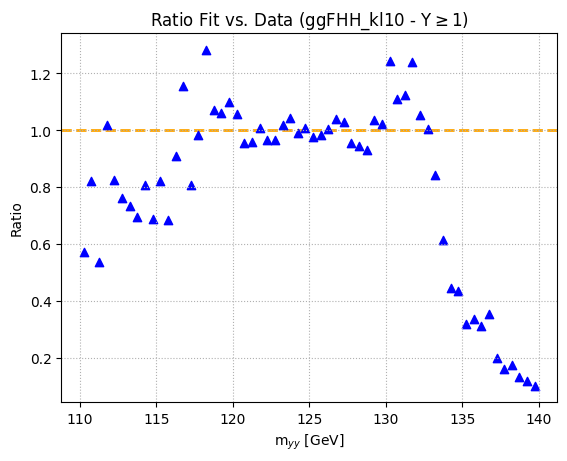

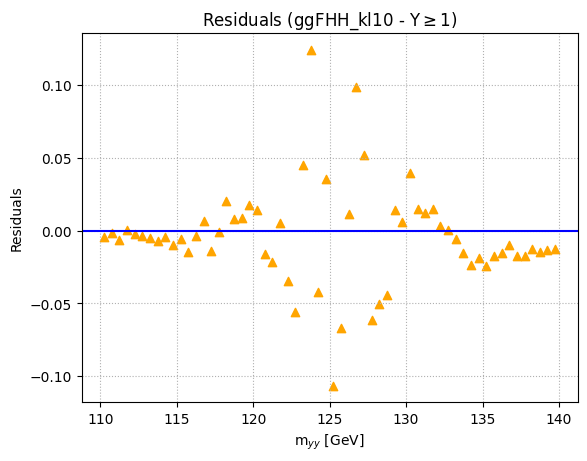

In [104]:
plot_ratio_red(myy_bin_centers, ggFHH_kl10_myy_ratio, ggFHH_kl10_myy_residuals, r'ggFHH_kl10 - Y$\geq$1', 'myy')

---
---

## All Signals Combined

In [105]:
#scale up factors
n_mbb = 10

n_myy = 10

#signal
signal_mbb = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb, VBFHH_mbb, ggFHH_kl1_mbb])

signal_myy = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy, VBFHH_mbb, ggFHH_kl1_myy])

signal_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights, VBFHH_weights, ggFHH_kl1_weights])

#scale up the HH samples
signal_mbb_mod = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb, np.tile(VBFHH_mbb, n_mbb), np.tile(ggFHH_kl1_mbb, n_mbb)])

signal_myy_mod = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy, np.tile(VBFHH_myy, n_myy), np.tile(ggFHH_kl1_myy, n_myy)])

signal_mod_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights, np.tile(VBFHH_weights, n_mbb), np.tile(ggFHH_kl1_weights, n_mbb)])

#background
bkg_mbb = np.concatenate([ggFH_mbb, ttH_mbb, qqZH_mbb, yybb_mbb])

bkg_myy = np.concatenate([ggFH_myy, ttH_myy, qqZH_myy, yybb_myy])

bkg_weights = np.concatenate([ggFH_weights, ttH_weights, qqZH_weights, yybb_weights])

### Functions

In [106]:
def signal_func_mbb(x, N1, N2):
    return N1 * dscb_func(x, *VBFHH_mbb_popt) + cb_func(x, *ggFH_mbb_popt) + dscb_func(x, *ttH_mbb_popt) +\
            cb_func(x, *qqZH_mbb_popt) + N2 * gauss_func(x, *yybb_mbb_popt) + N1 * dscb_func(x, *ggFHH_kl1_mbb_popt)

signal_labels = [r'$\mu$', r'$\mu_b$']
signal_units = ['', '']

In [107]:
def bkg_func_mbb(x, N):
    return cb_func(x, *ggFH_mbb_popt) + dscb_func(x, *ttH_mbb_popt) +\
            cb_func(x, *qqZH_mbb_popt) + N * gauss_func(x, *yybb_mbb_popt)

bkg_labels = [r'$\mu_b$']
bkg_units = ['']

In [108]:
def signal_func_myy(x, N1, N2, l):
    return N1 * dscb_func(x, *VBFHH_myy_popt) + dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N2 * exp_fit(x, yybb_myy_popt[0], l) + N1 * dscb_func(x, *ggFHH_kl1_myy_popt)

signal_myy_labels = [r'$\mu$', r'$\mu_b$', r'$\lambda$']
signal_myy_units = ['', '', r'GeV$^{-1}$']

In [109]:
yybb_myy_popt

array([1.22739464e+02, 2.62911072e-05])

In [110]:
def bkg_func_myy(x, N, l):
    return dscb_func(x, *ggFH_myy_popt) + dscb_func(x, *ttH_myy_popt) +\
            dscb_func(x, *qqZH_myy_popt) + N * exp_fit(x, yybb_myy_popt[0], l)

bkg_myy_labels = [r'$\mu_b$', r'$\lambda$']
bkg_myy_units = ['', r'GeV$^{-1}$']

In [111]:
import scipy.stats as st

def poisson_error(x):
    high_err = st.chi2.ppf(1. - (1. - 0.68)/2. , 2.* (x + 1.)) / 2. - x - 1
    low_err = x - st.chi2.ppf((1. - 0.68)/2., 2.*x) / 2
    return [low_err, high_err]

### m$_{b\bar{b}}$

In [112]:
#signal_mbb_err = get_errors(signal_mbb, signal_weights, mbb_bins, mbb_bin_num)

#signal_mod_mbb_err = get_errors(signal_mbb_mod, signal_mod_weights, mbb_bins, mbb_bin_num)

#bkg_mbb_err = get_errors(bkg_mbb, bkg_weights, mbb_bins, mbb_bin_num)

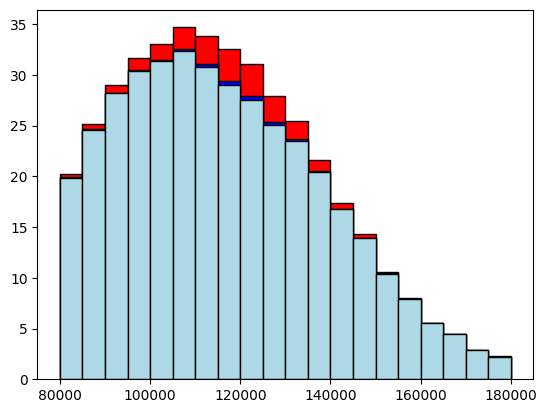

In [113]:
signal_mod_mbb_counts, signal_mod_mbb_bins, _ = plt.hist(signal_mbb_mod, bins=mbb_bins, range=mbb_range, color='red',\
                                    edgecolor='black', weights=signal_mod_weights)

signal_mbb_counts, signal_mbb_bins, _ = plt.hist(signal_mbb, bins=mbb_bins, range=mbb_range, color='blue',\
                                    edgecolor='black', weights=signal_weights)

bkg_mbb_counts, bkg_mbb_bins, _ = plt.hist(bkg_mbb, bins=mbb_bins, range=mbb_range, color='lightblue',\
                                    edgecolor='black', weights=bkg_weights)

In [114]:
signal_mbb_err = poisson_error(signal_mbb_counts)

signal_mod_mbb_err = poisson_error(signal_mod_mbb_counts)

bkg_mbb_err = poisson_error(bkg_mbb_counts)

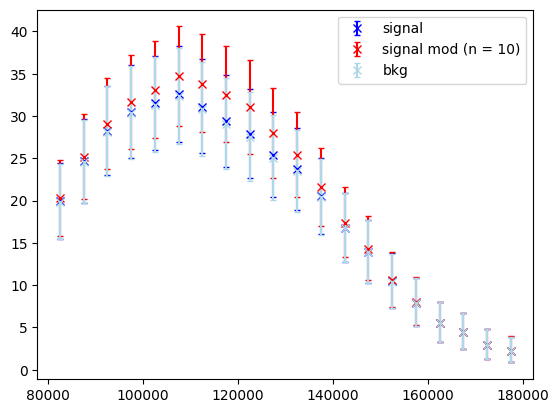

In [115]:
plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='', label='signal', capsize=2)

plt.errorbar(mbb_bin_centers, signal_mod_mbb_counts, yerr=signal_mod_mbb_err, marker='x', color='red', ls='', label='signal mod (n = {})'.format(n_mbb), capsize=2)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, yerr=bkg_mbb_err, marker='x', color='lightblue', ls='', label='bkg', capsize=2)

_=plt.legend()

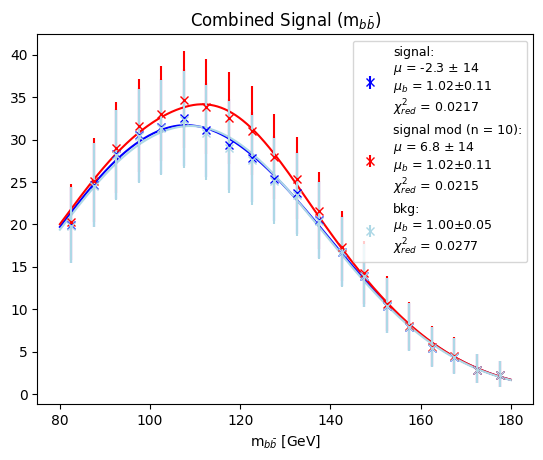

In [116]:
#signal
signal_mbb_popt, signal_mbb_pcov = curve_fit(signal_func_mbb, mbb_bin_centers, signal_mbb_counts, p0=[1,1], sigma=np.mean(signal_mbb_err,axis=0), absolute_sigma=True)

signal_mbb_ratio, signal_mbb_residuals, signal_mbb_chi_red, signal_mbb_chi \
= fit_evaluation(signal_func_mbb, mbb_bin_centers, signal_mbb_counts, np.mean(signal_mbb_err), signal_mbb_popt)

signal_mbb_legend = get_legend(signal_mbb_popt, signal_mbb_pcov, signal_mbb_chi_red, signal_labels, signal_units)

#modified signal
signal_mod_mbb_popt, signal_mod_mbb_pcov = curve_fit(signal_func_mbb, mbb_bin_centers, signal_mod_mbb_counts, p0=[n_mbb,1], sigma=np.mean(signal_mod_mbb_err,axis=0), absolute_sigma=True)

signal_mod_mbb_ratio, signal_mod_mbb_residuals, signal_mod_mbb_chi_red, signal_mod_mbb_chi \
= fit_evaluation(signal_func_mbb, mbb_bin_centers, signal_mod_mbb_counts, np.mean(signal_mod_mbb_err), signal_mod_mbb_popt)

signal_mod_mbb_legend = get_legend(signal_mod_mbb_popt, signal_mod_mbb_pcov, signal_mod_mbb_chi_red, signal_labels, signal_units)

#background
bkg_mbb_popt, bkg_mbb_pcov = curve_fit(bkg_func_mbb, mbb_bin_centers, bkg_mbb_counts, p0=1, sigma=np.mean(bkg_mbb_err,axis=0), absolute_sigma=True)

bkg_mbb_ratio, bkg_mbb_residuals, bkg_mbb_chi_red, bkg_mbb_chi \
= fit_evaluation(bkg_func_mbb, mbb_bin_centers, bkg_mbb_counts, np.mean(bkg_mbb_err), bkg_mbb_popt)

bkg_mbb_legend = get_legend(bkg_mbb_popt, bkg_mbb_pcov, bkg_mbb_chi_red, bkg_labels, bkg_units)

#plot the results
plt.title(r'Combined Signal (m$_{b\bar{b}}$)')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mbb_popt), color='blue')

plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mod_mbb_popt), color='red')

plt.plot(mbb_plot, bkg_func_mbb(mbb_plot, *bkg_mbb_popt), color='lightblue')

plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='', label='signal:\n'+signal_mbb_legend)

plt.errorbar(mbb_bin_centers, signal_mod_mbb_counts, yerr=signal_mbb_err, marker='x', color='red', ls='', label='signal mod (n = {}):\n'.format(n_mbb)+signal_mod_mbb_legend)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, yerr=signal_mbb_err, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_mbb_legend)

_=plt.legend(fontsize=9)

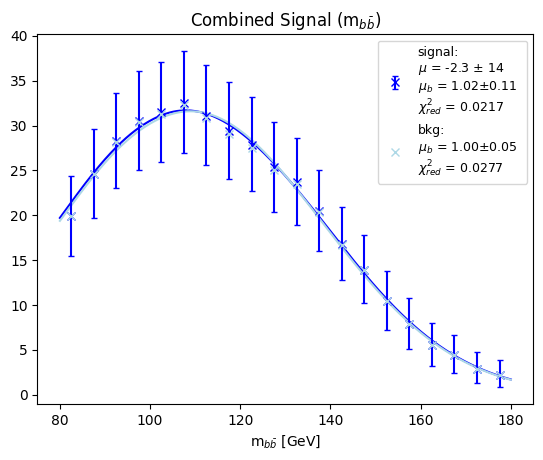

In [117]:
plt.title(r'Combined Signal (m$_{b\bar{b}}$)')
plt.xlabel(r'm$_{b\bar{b}}$ [GeV]')

plt.xticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

plt.plot(mbb_plot, signal_func_mbb(mbb_plot, *signal_mbb_popt), color='blue')

plt.plot(mbb_plot, bkg_func_mbb(mbb_plot, *bkg_mbb_popt), color='lightblue')

plt.errorbar(mbb_bin_centers, signal_mbb_counts, yerr=signal_mbb_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_mbb_legend, capsize=2)

plt.errorbar(mbb_bin_centers, bkg_mbb_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_mbb_legend)

plt.legend(fontsize=9)

plt.savefig('./Plots/combined_signals/Y1_mbb.pdf', format='pdf')

---

### m$_{\gamma\gamma}$

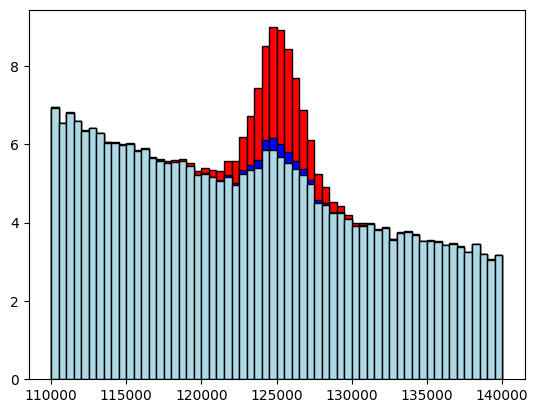

In [118]:
signal_mod_myy_counts, signal_mod_myy_bins, _ = plt.hist(signal_myy_mod, bins=myy_bins, range=myy_range, color='red',\
                                    edgecolor='black', weights=signal_mod_weights)

signal_myy_counts, signal_myy_bins, _ = plt.hist(signal_myy, bins=myy_bins, range=myy_range, color='blue',\
                                    edgecolor='black', weights=signal_weights)

bkg_myy_counts, bkg_myy_bins, _ = plt.hist(bkg_myy, bins=myy_bins, range=myy_range, color='lightblue',\
                                    edgecolor='black', weights=bkg_weights)

In [119]:
signal_myy_err = poisson_error(signal_myy_counts)

signal_mod_myy_err = poisson_error(signal_mod_myy_counts)

bkg_myy_err = poisson_error(bkg_myy_counts)

In [120]:
#signal_myy_err = get_errors(signal_myy, signal_weights, myy_bins, myy_bin_num)

#signal_mod_myy_err = get_errors(signal_myy_mod, signal_mod_weights, myy_bins, myy_bin_num)

#bkg_myy_err = get_errors(bkg_myy, bkg_weights, myy_bins, myy_bin_num)

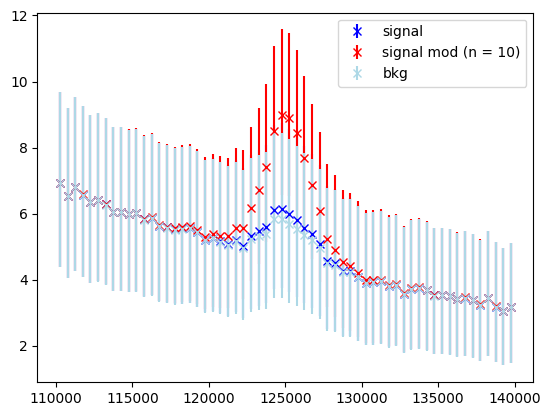

In [121]:
plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='', label='signal')

plt.errorbar(myy_bin_centers, signal_mod_myy_counts, yerr=signal_myy_err, marker='x', color='red', ls='', label='signal mod (n = {})'.format(n_mbb))

plt.errorbar(myy_bin_centers, bkg_myy_counts, yerr=signal_myy_err, marker='x', color='lightblue', ls='', label='bkg')

_=plt.legend()

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


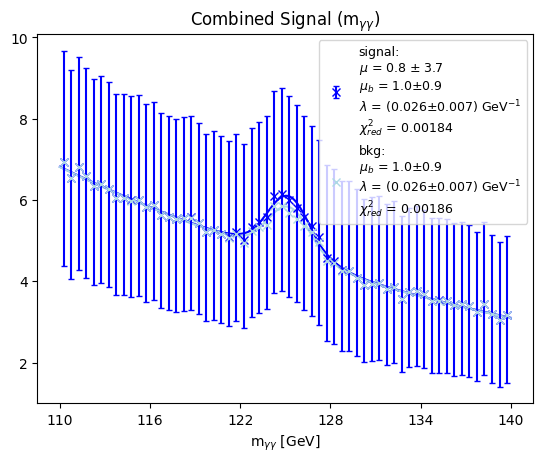

In [122]:
#signal
signal_myy_popt, signal_myy_pcov = curve_fit(signal_func_myy, myy_bin_centers, signal_myy_counts,\
                                             sigma = np.mean(signal_myy_err, axis=0), p0=[1,120,2.76e-5], absolute_sigma=True)

signal_myy_ratio, signal_myy_residuals, signal_myy_chi_red, signal_myy_chi \
= fit_evaluation(signal_func_myy, myy_bin_centers, signal_myy_counts, np.mean(signal_myy_err, axis=0), signal_myy_popt)

signal_myy_legend = get_legend(signal_myy_popt, signal_myy_pcov, signal_myy_chi_red, signal_myy_labels, signal_myy_units)

#modified signal
signal_mod_myy_popt, signal_mod_myy_pcov = curve_fit(signal_func_myy, myy_bin_centers, signal_mod_myy_counts,\
                                                     sigma = np.mean(signal_mod_myy_err, axis=0), p0=[n_mbb,120,2.76e-5], absolute_sigma=True)

signal_mod_myy_ratio, signal_mod_myy_residuals, signal_mod_myy_chi_red, signal_mod_myy_chi \
= fit_evaluation(signal_func_myy, myy_bin_centers, signal_mod_myy_counts, np.mean(signal_mod_myy_err, axis=0), signal_mod_myy_popt)

signal_mod_myy_legend = get_legend(signal_mod_myy_popt, signal_mod_myy_pcov, signal_mod_myy_chi_red, signal_myy_labels, signal_myy_units)

#background
bkg_myy_popt, bkg_myy_pcov = curve_fit(bkg_func_myy, myy_bin_centers, bkg_myy_counts, sigma = np.mean(bkg_myy_err, axis=0), p0=[120, 2.76e-5], absolute_sigma=True)

bkg_myy_ratio, bkg_myy_residuals, bkg_myy_chi_red, bkg_myy_chi \
= fit_evaluation(bkg_func_myy, myy_bin_centers, bkg_myy_counts, np.mean(bkg_myy_err, axis=0), bkg_myy_popt)

bkg_myy_legend = get_legend(bkg_myy_popt, bkg_myy_pcov, bkg_myy_chi_red, bkg_myy_labels, bkg_myy_units)

#plot the results
#plt.figure(figsize=(10,4))
#from scipy.interpolate import interp1d
#f = interp1d(mbb_bin_centers, , kind='cubic')
#x_smooth = np.linspace(x.min(), x.max(), 300)
#y_smooth = f(myy_bin_centers)

plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy(myy_plot, *signal_myy_popt), color='blue')

#plt.plot(myy_plot, signal_func_myy(myy_plot, *signal_mod_myy_popt), color='red')

plt.plot(myy_plot, bkg_func_myy(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err,\
             marker='x', color='blue', ls='', label='signal:\n'+signal_myy_legend, capsize=2)

#plt.fill_between(myy_bin_centers, signal_myy_counts-signal_myy_err[0], signal_myy_counts+signal_myy_err[1], color='pink')

#plt.errorbar(myy_bin_centers, signal_mod_myy_counts, yerr=signal_myy_err, marker='x', color='red', ls='', label='signal mod (n = {}):\n'.format(n_mbb)+signal_mod_myy_legend)

plt.errorbar(myy_bin_centers, bkg_myy_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=9)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


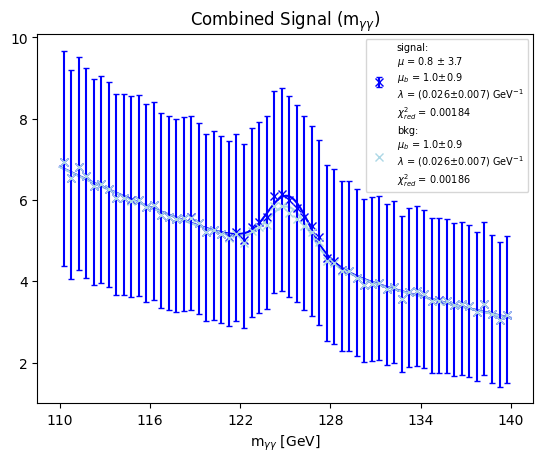

In [123]:
plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xticks(np.linspace(myy_min,myy_max,6),(np.linspace(myy_min,myy_max,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy(myy_plot, *signal_myy_popt), color='blue')

plt.plot(myy_plot, bkg_func_myy(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_myy_legend, capsize=2)

plt.errorbar(myy_bin_centers, bkg_myy_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=7)

plt.savefig('./Plots/combined_signals/Y1_myy.pdf', format='pdf')

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


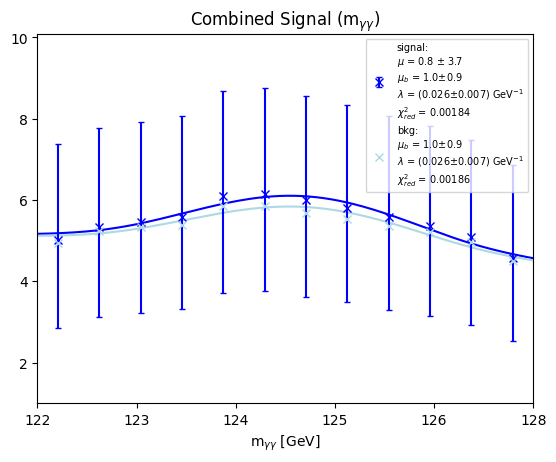

In [124]:
plt.title(r'Combined Signal (m$_{\gamma\gamma}$)')
plt.xlabel(r'm$_{\gamma\gamma}$ [GeV]')

plt.xlim(122e3,128e3)

plt.xticks(np.linspace(122e3,128e3,6),(np.linspace(122e3,128e3,6)/1e3).astype(int))

plt.plot(myy_plot, signal_func_myy(myy_plot, *signal_myy_popt), color='blue')

plt.plot(myy_plot, bkg_func_myy(myy_plot, *bkg_myy_popt), color='lightblue')

plt.errorbar(myy_bin_centers, signal_myy_counts, yerr=signal_myy_err, marker='x', color='blue', ls='',\
             label='signal:\n'+signal_myy_legend, capsize=2)

plt.errorbar(myy_bin_centers, bkg_myy_counts, marker='x', color='lightblue', ls='', label='bkg:\n'+bkg_myy_legend)

_=plt.legend(fontsize=7)

plt.savefig('./Plots/combined_signals/Y1_myy_zoom.pdf', format='pdf')

## Save Results

In [125]:
popt_mbb_arrays = np.array([VBFHH_mbb_popt, ggFH_mbb_popt, ttH_mbb_popt, qqZH_mbb_popt, yybb_mbb_popt, ggFHH_kl1_mbb_popt, ggFHH_kl10_mbb_popt], dtype=object)

pcov_mbb_arrays = np.array([VBFHH_mbb_pcov, ggFH_mbb_pcov, ttH_mbb_pcov, qqZH_mbb_pcov, yybb_mbb_pcov, ggFHH_kl1_mbb_pcov, ggFHH_kl10_mbb_pcov], dtype=object)

popt_myy_arrays = np.array([VBFHH_myy_popt, ggFH_myy_popt, ttH_myy_popt, qqZH_myy_popt, yybb_myy_popt, ggFHH_kl1_myy_popt, ggFHH_kl10_myy_popt], dtype=object)

pcov_myy_arrays = np.array([VBFHH_myy_pcov, ggFH_myy_pcov, ttH_myy_pcov, qqZH_myy_pcov, yybb_myy_pcov, ggFHH_kl1_myy_pcov, ggFHH_kl10_myy_pcov], dtype=object)

In [126]:
np.savez('Samples-Arrays/Y1-Arrays/Y1-Fitparams.npz', popt_mbb=popt_mbb_arrays, pcov_mbb=pcov_mbb_arrays, popt_myy=popt_myy_arrays, pcov_myy=pcov_myy_arrays)

In [127]:
popt_mbb_signals = np.array([signal_mbb_popt, signal_mod_mbb_popt, bkg_mbb_popt], dtype=object)

pcov_mbb_signals = np.array([signal_mbb_pcov, signal_mod_mbb_pcov, bkg_mbb_pcov], dtype=object)

popt_myy_signals = np.array([signal_myy_popt, signal_mod_myy_popt, bkg_myy_popt], dtype=object)

pcov_myy_signals = np.array([signal_myy_pcov, signal_mod_myy_pcov, bkg_myy_pcov], dtype=object)

In [128]:
np.savez('Samples-Arrays/Y1-Arrays/Y1-Signalfit.npz', popt_mbb=popt_mbb_signals, pcov_mbb=pcov_mbb_signals, popt_myy=popt_myy_signals, pcov_myy=pcov_myy_signals)

## 2D Fit

### VBFHH

In [129]:
def VBFHH_2d(myy, mbb):
    return dscb_func(myy, *VBFHH_myy_popt) * dscb_func(mbb, *VBFHH_mbb_popt)

In [130]:
VBFHH_hist2d, VBFHH_hist2d_xedges, VBFHH_hist2d_yedges = \
np.histogram2d(VBFHH_myy, VBFHH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=VBFHH_weights)

In [131]:
VBFHH_2d_int_hist = np.sum(VBFHH_hist2d) * 500 * 5000

VBFHH_2d_int_hist

213004.6506746692

In [132]:
from scipy import integrate

# Calculate the double integral
VBFHH_2d_int, VBFHH_abserr = integrate.dblquad(VBFHH_2d, mbb_min, mbb_max, myy_min, myy_max)

VBFHH_2d_int

19062.737874051683

In [133]:
VBFHH_2d_N = VBFHH_2d_int_hist/VBFHH_2d_int

VBFHH_2d_N

11.173875026871793

In [134]:
xedges = VBFHH_hist2d_xedges
yedges = VBFHH_hist2d_yedges

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Size of bars
dx = dy = (xedges[1] - xedges[0]) * np.ones_like(zpos)

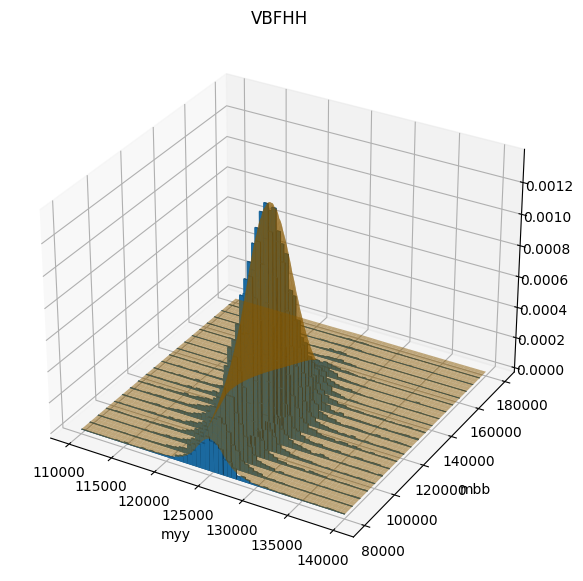

In [135]:
dz = VBFHH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',alpha=1)

MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000), indexing='ij')

ax.plot_surface(MYY, MBB, VBFHH_2d(MYY,MBB) * VBFHH_2d_N, alpha=0.5, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('VBFHH')

plt.show()

### ggFH

In [136]:
def ggFH_2d(myy, mbb):
    return dscb_func(myy, *ggFH_myy_popt) * cb_func(mbb, *ggFH_mbb_popt)

In [137]:
ggFH_hist2d, ggFH_hist2d_xedges, ggFH_hist2d_yedges = \
np.histogram2d(ggFH_myy, ggFH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ggFH_weights)

In [138]:
ggFH_2d_int_hist = np.sum(ggFH_hist2d) * 500 * 5000

ggFH_2d_int_hist

4712937.342395219

In [139]:
from scipy import integrate

# Calculate the double integral
ggFH_2d_int, ggFH_abserr = integrate.dblquad(ggFH_2d, mbb_min, mbb_max, myy_min, myy_max)

ggFH_2d_int

11331811.066214494

In [140]:
ggFH_2d_N = ggFH_2d_int_hist/ggFH_2d_int

ggFH_2d_N

0.4159032757302777

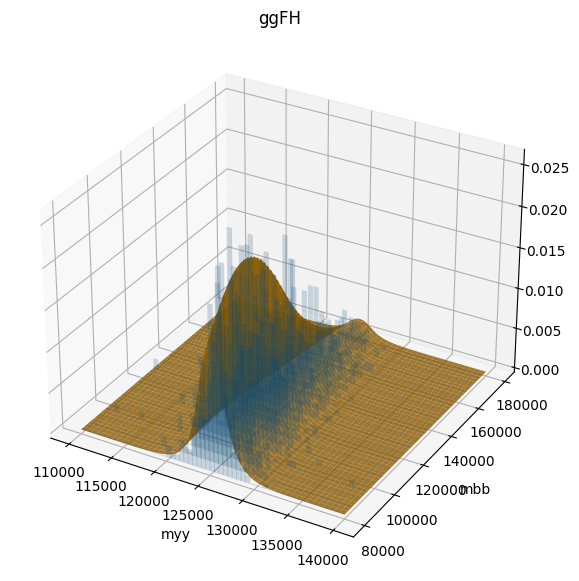

In [141]:
ggFH_dz = ggFH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ggFH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ggFH_2d(MYY,MBB) * ggFH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ggFH')

plt.show()

### ttH

In [142]:
def ttH_2d(myy, mbb):
    return dscb_func(myy, *ttH_myy_popt) * dscb_func(mbb, *ttH_mbb_popt)

In [143]:
ttH_hist2d, ttH_hist2d_xedges, ttH_hist2d_yedges = \
np.histogram2d(ttH_myy, ttH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ttH_weights)

In [144]:
ttH_2d_int_hist = np.sum(ttH_hist2d) * 500 * 5000

ttH_2d_int_hist

10075734.289154513

In [145]:
from scipy import integrate

# Calculate the double integral
ttH_2d_int, ttH_abserr = integrate.dblquad(ttH_2d, mbb_min, mbb_max, myy_min, myy_max)

ttH_2d_int

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


51609261.64133012

In [146]:
ttH_2d_N = ttH_2d_int_hist/ttH_2d_int

ttH_2d_N

0.19523112652101163

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


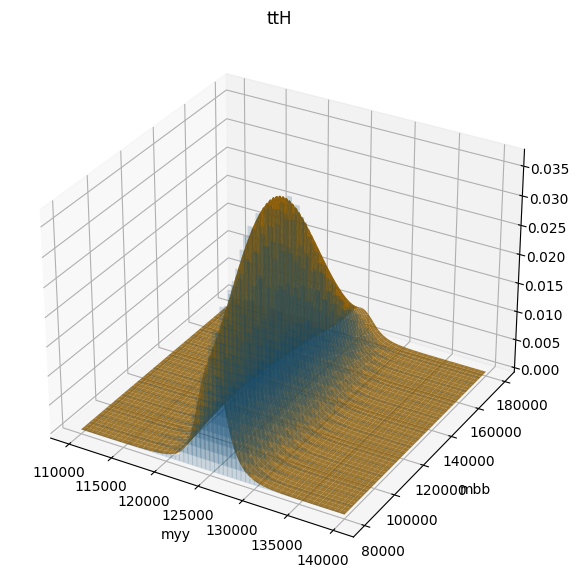

In [147]:
ttH_dz = ttH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ttH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ttH_2d(MYY,MBB) * ttH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ttH')

plt.show()

### qqZH

In [148]:
def qqZH_2d(myy, mbb):
    return dscb_func(myy, *qqZH_myy_popt) * cb_func(mbb, *qqZH_mbb_popt)

In [149]:
qqZH_hist2d, qqZH_hist2d_xedges, qqZH_hist2d_yedges = \
np.histogram2d(qqZH_myy, qqZH_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=qqZH_weights)

In [150]:
qqZH_2d_int_hist = np.sum(qqZH_hist2d) * 500 * 5000

qqZH_2d_int_hist

5095373.854864504

In [151]:
from scipy import integrate

# Calculate the double integral
qqZH_2d_int, qqZH_abserr = integrate.dblquad(qqZH_2d, mbb_min, mbb_max, myy_min, myy_max)

qqZH_2d_int

12757638.461500177

In [152]:
qqZH_2d_N = qqZH_2d_int_hist/qqZH_2d_int

qqZH_2d_N

0.3993978878019825

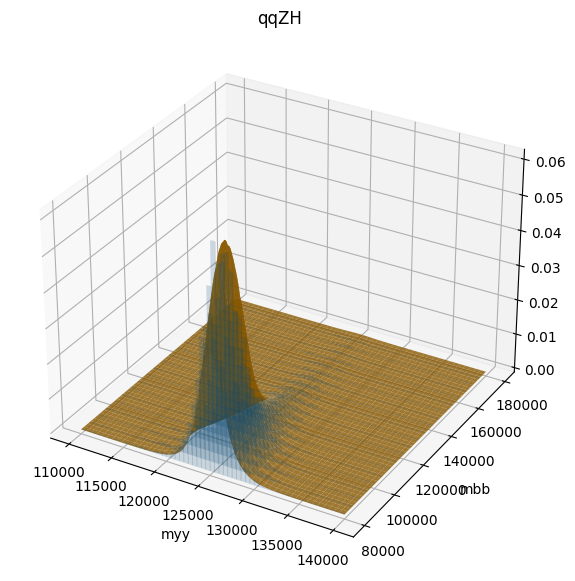

In [153]:
qqZH_dz = qqZH_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, qqZH_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, qqZH_2d(MYY,MBB) * qqZH_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('qqZH')

plt.show()

### yybb

In [154]:
def yybb_2d(myy, mbb):
    return exp_fit(myy, *yybb_myy_popt) * gauss_func(mbb, *yybb_mbb_popt)

In [155]:
yybb_hist2d, yybb_hist2d_xedges, yybb_hist2d_yedges = \
np.histogram2d(yybb_myy, yybb_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=yybb_weights)

In [156]:
yybb_2d_int_hist = np.sum(yybb_hist2d) * 500 * 5000

yybb_2d_int_hist

586753303.8979404

In [157]:
from scipy import integrate

# Calculate the double integral
yybb_2d_int, yybb_abserr = integrate.dblquad(yybb_2d, mbb_min, mbb_max, myy_min, myy_max)

yybb_2d_int

267314446100.4728

In [158]:
yybb_2d_N = yybb_2d_int_hist/yybb_2d_int

yybb_2d_N

0.00219499287246677

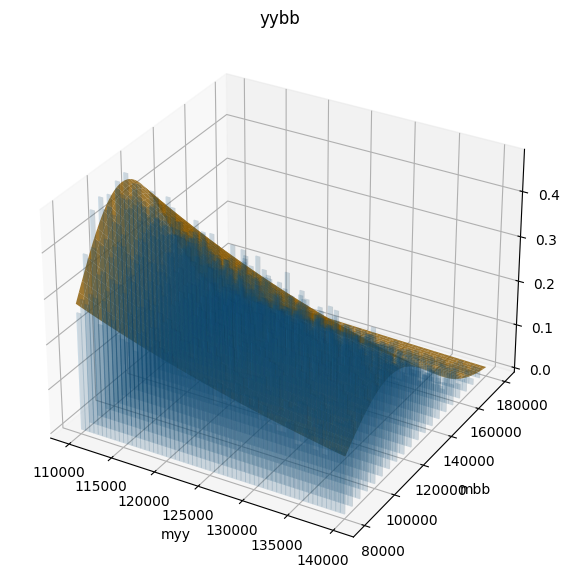

In [159]:
yybb_dz = yybb_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, yybb_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, yybb_2d(MYY,MBB) * yybb_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('yybb')

plt.show()

### ggFHH_kl1

In [160]:
def ggFHH_kl1_2d(myy, mbb):
    return dscb_func(myy, *ggFHH_kl1_myy_popt) * dscb_func(mbb, *ggFHH_kl1_mbb_popt)

In [161]:
ggFHH_kl1_hist2d, ggFHH_kl1_hist2d_xedges, ggFHH_kl1_hist2d_yedges = \
np.histogram2d(ggFHH_kl1_myy, ggFHH_kl1_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=ggFHH_kl1_weights)

In [162]:
ggFHH_kl1_2d_int_hist = np.sum(ggFHH_kl1_hist2d) * 500 * 5000

ggFHH_kl1_2d_int_hist

5934503.144822547

In [163]:
from scipy import integrate

# Calculate the double integral
ggFHH_kl1_2d_int, ggFHH_kl1_abserr = integrate.dblquad(ggFHH_kl1_2d, mbb_min, mbb_max, myy_min, myy_max)

ggFHH_kl1_2d_int

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in scalar power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


14647579.91071689

In [164]:
ggFHH_kl1_2d_N = ggFHH_kl1_2d_int_hist/ggFHH_kl1_2d_int

ggFHH_kl1_2d_N

0.40515246757456314

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


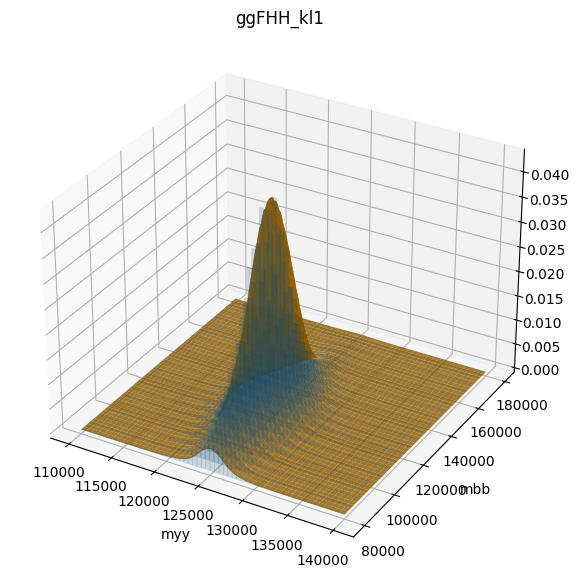

In [165]:
ggFHH_kl1_dz = ggFHH_kl1_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, ggFHH_kl1_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, ggFHH_kl1_2d(MYY,MBB) * ggFHH_kl1_2d_N, alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('ggFHH_kl1')

plt.show()

### All Signals Combined

In [166]:
def signal_2d(myymbb, N1, N2, l):
    myy, mbb = myymbb
    return N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * cb_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * gauss_func(mbb, *yybb_mbb_popt) * exp_fit(myy, yybb_myy_popt[0], l) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

signal_2d_labels = [r'$\mu$', r'$\mu_b$', r'$\lambda_{\gamma\gamma}$']
signal_2d_units = ['', '', r'GeV$^{-1}$']

In [167]:
signal_hist2d, signal_hist2d_xedges, signal_hist2d_yedges = \
np.histogram2d(signal_myy, signal_mbb, bins=[myy_bins, mbb_bins], range=[myy_range, mbb_range], weights=signal_weights)

signal_2d_err = poisson_error(signal_hist2d)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


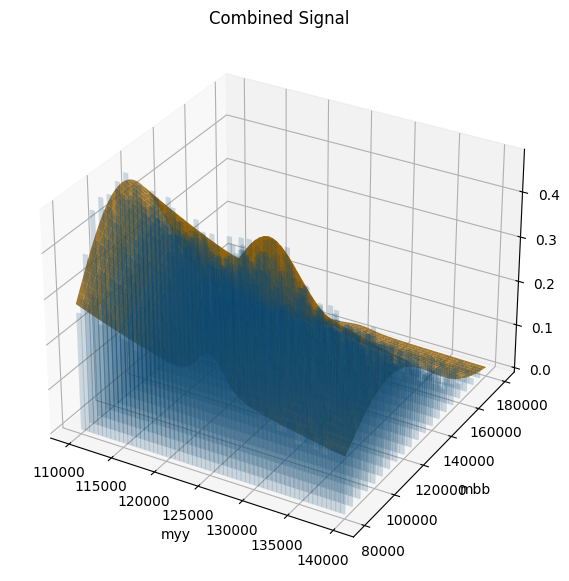

In [168]:
signal_dz = signal_hist2d.ravel()

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), 1, 1, yybb_myy_popt[1]), alpha=0.8, color='orange')

ax.set_xlabel('myy')
ax.set_ylabel('mbb')
plt.title('Combined Signal')

plt.show()

In [169]:
def signal_2d_fit(myymbb, N1, N2, l):
    myy, mbb = myymbb
    value = N1 * VBFHH_2d_N * dscb_func(mbb, *VBFHH_mbb_popt) * dscb_func(myy, *VBFHH_myy_popt) \
            + ggFH_2d_N * cb_func(mbb, *ggFH_mbb_popt) * dscb_func(myy, *ggFH_myy_popt) \
                + ttH_2d_N * dscb_func(mbb, *ttH_mbb_popt) * dscb_func(myy, *ttH_myy_popt) \
                    + qqZH_2d_N * cb_func(mbb, *qqZH_mbb_popt) * dscb_func(myy, *qqZH_myy_popt) \
                        + N2 * yybb_2d_N * gauss_func(mbb, *yybb_mbb_popt) * exp_fit(myy, yybb_myy_popt[0], l) \
                            + N1 * ggFHH_kl1_2d_N * dscb_func(mbb, *ggFHH_kl1_mbb_popt) * dscb_func(myy, *ggFHH_kl1_myy_popt)

    return value.ravel()

In [170]:
MYY_bin_centers, MBB_bin_centers = np.meshgrid(myy_bin_centers, mbb_bin_centers, indexing='ij')

signal_2d_popt, signal_2d_pcov = curve_fit(signal_2d_fit, (MYY_bin_centers,MBB_bin_centers), signal_hist2d.ravel(), \
                                           sigma=np.mean(signal_2d_err, axis=0).ravel(), p0=[1, 1, yybb_myy_popt[1]], absolute_sigma=True)

signal_2d_chi_red = np.sum( (signal_2d_fit((MYY_bin_centers,MBB_bin_centers),*signal_2d_popt)-signal_hist2d.ravel())**2 / np.mean(signal_2d_err, axis=0).ravel()**2 )

signal_2d_legend = get_legend(signal_2d_popt, signal_2d_pcov, signal_2d_chi_red, signal_2d_labels, signal_2d_units)

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


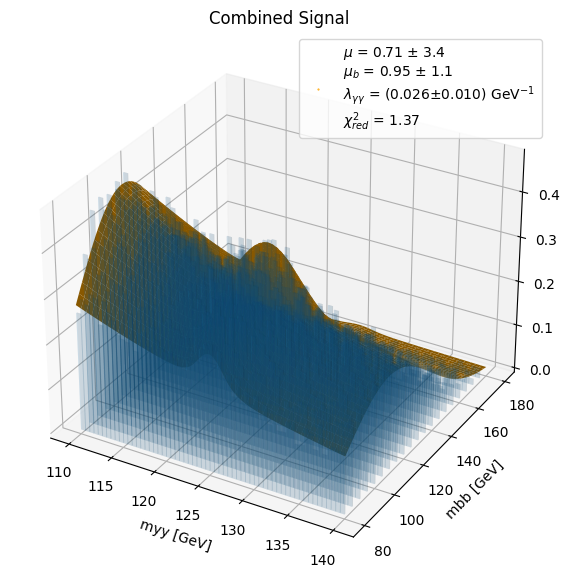

<Figure size 640x480 with 0 Axes>

In [171]:
import matplotlib.lines as mlines

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), *signal_2d_popt), alpha=1, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('Combined Signal')

proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=signal_2d_legend)
ax.legend(handles=[proxy])

plt.show()

plt.savefig('./Plots/2D-plots/Y1_2d.pdf', format='pdf')

In [172]:
np.savez('Samples-Arrays/Y1-Arrays/Y1-Signalfit_2D.npz', popt=signal_2d_popt, pcov=signal_2d_pcov)

In [173]:
signal_2d((MYY_bin_centers,MBB_bin_centers), *signal_2d_popt).ravel() - signal_hist2d.ravel()

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


array([ 0.03965593, -0.02820745, -0.06743376, ..., -0.00389   ,
        0.00701491, -0.00884128])

In [174]:
yybb_myy_popt[1]

2.629110715070195e-05

In [175]:
signal_2d((MYY_bin_centers,MBB_bin_centers), 1, 1, yybb_myy_popt[0]).ravel() - signal_hist2d.ravel()

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


array([-0.26175942, -0.37557002, -0.45614994, ..., -0.03264813,
       -0.01309095, -0.02249077])

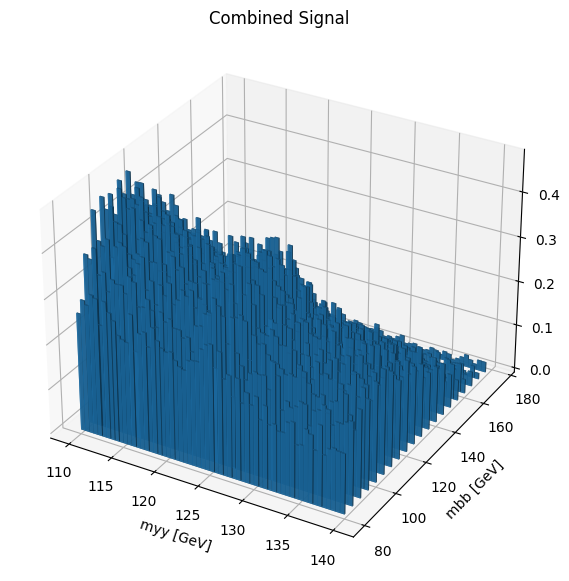

In [176]:
import matplotlib.lines as mlines

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.8)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

#surf = ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), *signal_2d_popt), alpha=0.8, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('Combined Signal')

#proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=signal_2d_legend)
#ax.legend(handles=[proxy])

plt.show()

/tmp/ipykernel_336/433496356.py:17: RuntimeWarning: invalid value encountered in power
  left = N * A_L * (B_L - (x - mu) / sigma) ** -n_L


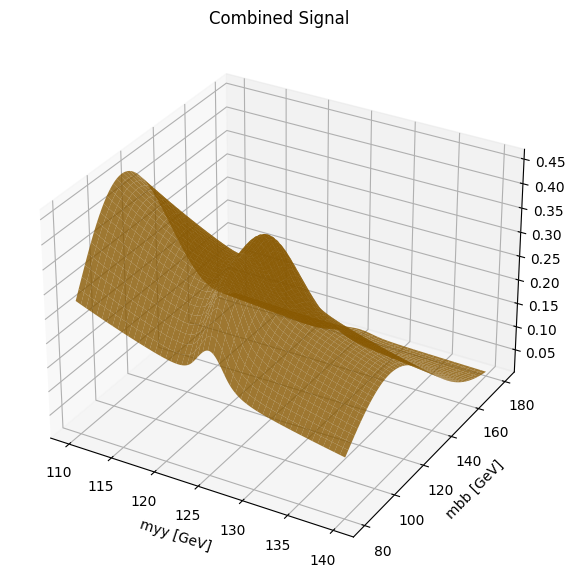

In [177]:
import matplotlib.lines as mlines

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_xticks(np.linspace(myy_min,myy_max,7),(np.linspace(myy_min,myy_max,7)/1e3).astype(int))
ax.set_yticks(np.linspace(mbb_min,mbb_max,6),(np.linspace(mbb_min,mbb_max,6)/1e3).astype(int))

#ax.bar3d(xpos, ypos, zpos, dx, dy, signal_dz, zsort='average',alpha=0.1)

#MYY, MBB = np.meshgrid(np.linspace(myy_min,myy_max,1000),np.linspace(mbb_min,mbb_max,1000))

surf = ax.plot_surface(MYY, MBB, signal_2d((MYY,MBB), *signal_2d_popt), alpha=0.8, color='orange')

ax.set_xlabel('myy [GeV]')
ax.set_ylabel('mbb [GeV]')
plt.title('Combined Signal')

#proxy = mlines.Line2D([0],[0], color='orange', marker='.', linestyle='None', markersize=1, label=signal_2d_legend)
#ax.legend(handles=[proxy])

plt.show()